# 자본시장과 회계정보 기말 페이퍼 #1: PBR의 평균회귀 현상
* 갑자기 PBR이 확 뛰거나 확 죽은 경우 향후 몇년간 PBR은 정상 수준으로 회귀하는가?
* 만약 회귀하는 경우, 장부가치가 상승하는가? 아니면 주가가 그에 맞추어지는 것인가?

### import packages

In [74]:
# Load Packages
import numpy as np
import pandas as pd
from pandas_datareader import data
import matplotlib.pyplot as plt
import OpenDartReader # https://github.com/FinanceData/OpenDartReader
import FinanceDataReader as fdr # https://financedata.github.io/posts/finance-data-reader-users-guide.html
from marcap import marcap_data # https://financedata.github.io/marcap/
import datetime as dt
from tqdm import tqdm
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy as sp


# 1. Dataset pull

## i) 주가 데이터
- 한국거래소의 거래 데이터를 이용해서 market cap 확인
    - Adj.price 없긴 한데… 주식수익률과 상관없이 PBR만을 보게 되는 것이니 그대로 진행
    - 상장폐지된 종목들도 포함되어있습니다. 이들은 0으로 치는 것이 맞을까요?
        - 상환가격을 찾아봐야할 것 같은데, 이게 합병이 되는 경우 돈이 아니라 주식으로 주는 경우도 있어서 데이터를 찾거나 cleansing하기 매우 어려운 부분입니다.
        - 어차피 M&A로 상장폐지되는 경우도 기업가치가 많이 떨어져서 0이 되는 경우도 많을 텐데,,,
        - 상장폐지된 종목을 둘로 나눌 예정입니다.
            - 정당한 해산사유가 있거나, M&A가 되는 이유 등으로 상장폐지가 된 경우
            - 회사가 망하다시피해서 상장폐지되는 경우
            
             → 이 경우 둘 다 넣는 경우, 회사가 망하는 경우만 넣는 경우, 둘 다 안넣는 경우 세 가지를 모두 살펴본 뒤 결론을 내리기 적절한 데이터를 쓰도록 하겠습니다.

In [5]:
# marcap data에서 pull합니다.
# 필요 시 ! git clone "https://github.com/FinanceData/marcap.git" marcap 명령어를 통해 pull 가능(이 폴더 내 terminal에서 실행할 것)

pricedf = marcap_data('2014-03-15', '2022-11-03') # 1995-05-02에서부터 2022-11-03까지의 모든 데이터 import - 시간이 꽤 걸림(약 36초, 1.6G memory usage, 12199234 rows)
pricedf = pricedf[pricedf['Market'] == 'KOSPI']
pricedf = pricedf.reset_index(drop=False) # Date 따로 column으로 빼주기
pricedf.head(5)

,Date,Code,Name,Market,Dept,Close,ChangeCode,Changes,ChagesRatio,Open,High,Low,Volume,Amount,Marcap,Stocks,MarketId,Rank
0,2014-03-17,005930,삼성전자,KOSPI,NaN,1266000,2,-9000,-0.71,1275000,1276000,1258000,176400,223045315000,186480960642000,147299337,STK,1
1,2014-03-17,005380,현대차,KOSPI,NaN,234000,1,5000,2.18,229000,234000,229000,334656,77783013500,51544696086000,220276479,STK,2
2,2014-03-17,012330,현대모비스,KOSPI,NaN,301000,1,5000,1.69,294500,303500,294500,105594,31789696000,29300502763000,97343863,STK,3
3,2014-03-17,035420,NAVER,KOSPI,NaN,801000,2,-9000,-1.11,803000,822000,792000,131136,105096454000,26403105879000,32962679,STK,4
4,2014-03-17,000660,SK하이닉스,KOSPI,NaN,36700,2,-1250,-3.29,37400,37450,36600,4053729,149309687150,26064372699700,710200891,STK,5


## ii) 재무제표 데이터
- OpenDart 전자공시 API를 통해 손쉽게 데이터를 Pulling할 수 있습니다.
- 파이썬 라이브러리를 이용하면 훨씬 더 쉽게 이용할 수 있습니다.
    - API를 어떻게 쓸 줄 아느냐가 중요한 것이 아니므로 이미 제작된 Package를 사용합니다.
- pip에 올라와있는 OpenDartReader는 손쉽게 해당 데이터를 Pandas DF형식으로 변환해줍니다…! 최고!
- 아... 2015년까지밖에 없네...
- 사업보고서가 공시되는 618개 기업을 대상으로 진행(이외 리츠나 우선주같은 것은 반영 X)

### Code
- 1분기보고서 : 11013  
- 반기보고서 : 11012  
- 3분기보고서 : 11014  
- 사업보고서 : 11011

### Exchange rate
- 2013-03-15 : 1,111.50
- 2014-03-15 : 1,067.40
- 2015-03-15 : 1,130.90
- 2016-03-15 : 1,186.50
- 2017-03-15 : 1,147.30
- 2018-03-15 : 1,065.80
- 2019-03-15 : 1,132.70
- 2020-03-15 : 1,202.00
- 2021-03-15 : 1,130.70
- 2022-03-15 : 1,238.60	

In [3]:
# input api key, make an instance

api_key = 'a3abf38ce5deb602f64bbd23f57a59cb6a7c0723'
dart = OpenDartReader(api_key) 

# save exchange rate in dict
ex_rate = dict([(2013 , 1111.50),
(2014 , 1067.40),
(2015 , 1130.90),
(2016 , 1186.50),
(2017 , 1147.30),
(2018 , 1065.80),
(2019 , 1132.70),
(2020 , 1202.00),
(2021 , 1130.70),
(2022 , 1238.60)])	

In [ ]:
# OpenDart에서 재무제표 데이터를 전부 갖고오기 - 2014년 이전은 API로 안줌
# 2015년까지 주는데, 각각의 row에는 2기 전까지 제공해주니 2013~2021 총 9개년의 데이터 확보 가능
# 하루에 10,000개 밖에 전송해주지 않으니, 알아서 잘 모을 것
# 반기/분기보고서를 따로 갖고와야 할 필요가 있을까? 모으려면 모을 수 있음
# 흑흑... 이건 연결재무제표를 들고오는 코드입니다. 재무제표만 있는 기업거는 안들고오네요..... . .. . . .. . .. . .
'''
findf = pd.DataFrame()
for corp in pricedf.Code.unique():
    for y in range(2015,2022):
        try:
            tempdf = dart.finstate_all(corp, y)
            tempdf['Code'] = pd.Series([corp]*len(tempdf))
            findf = pd.concat([findf,tempdf])
        except:
            pass
findf.to_excel('findf.xlsx')
'''

In [34]:
dart.finstate('005930',2016,reprt_code='11013')


,rcept_no,reprt_code,bsns_year,corp_code,stock_code,fs_div,fs_nm,sj_div,sj_nm,account_nm,thstrm_nm,thstrm_dt,thstrm_amount,frmtrm_nm,frmtrm_dt,frmtrm_amount,ord,currency,thstrm_add_amount,frmtrm_add_amount
0,20160516003174,11013,2016,00126380,005930,CFS,연결재무제표,BS,재무상태표,유동자산,제 48 기1분기말,2016.03.31 현재,"126,587,169,000,000",제 47 기말,2015.12.31 현재,"124,814,725,000,000",1,KRW,NaN,NaN
1,20160516003174,11013,2016,00126380,005930,CFS,연결재무제표,BS,재무상태표,비유동자산,제 48 기1분기말,2016.03.31 현재,"114,652,620,000,000",제 47 기말,2015.12.31 현재,"117,364,796,000,000",3,KRW,NaN,NaN
2,20160516003174,11013,2016,00126380,005930,CFS,연결재무제표,BS,재무상태표,자산총계,제 48 기1분기말,2016.03.31 현재,"241,239,789,000,000",제 47 기말,2015.12.31 현재,"242,179,521,000,000",5,KRW,NaN,NaN
3,20160516003174,11013,2016,00126380,005930,CFS,연결재무제표,BS,재무상태표,유동부채,제 48 기1분기말,2016.03.31 현재,"49,049,500,000,000",제 47 기말,2015.12.31 현재,"50,502,909,000,000",7,KRW,NaN,NaN
4,20160516003174,11013,2016,00126380,005930,CFS,연결재무제표,BS,재무상태표,비유동부채,제 48 기1분기말,2016.03.31 현재,"13,864,103,000,000",제 47 기말,2015.12.31 현재,"12,616,807,000,000",9,KRW,NaN,NaN
5,20160516003174,11013,2016,00126380,005930,CFS,연결재무제표,BS,재무상태표,부채총계,제 48 기1분기말,2016.03.31 현재,"62,913,603,000,000",제 47 기말,2015.12.31 현재,"63,119,716,000,000",11,KRW,NaN,NaN
6,20160516003174,11013,2016,00126380,005930,CFS,연결재무제표,BS,재무상태표,이익잉여금,제 48 기1분기말,2016.03.31 현재,"183,218,614,000,000",제 47 기말,2015.12.31 현재,"185,132,014,000,000",17,KRW,NaN,NaN
7,20160516003174,11013,2016,00126380,005930,CFS,연결재무제표,BS,재무상태표,자본총계,제 48 기1분기말,2016.03.31 현재,"178,326,186,000,000",제 47 기말,2015.12.31 현재,"179,059,805,000,000",21,KRW,NaN,NaN
8,20160516003174,11013,2016,00126380,005930,CFS,연결재무제표,IS,손익계산서,매출액,제 48 기1분기,2016.01.01 ~ 2016.03.31,"49,782,252,000,000",제 47 기1분기,2015.01.01 ~ 2015.03.31,"47,117,918,000,000",23,KRW,"49,782,252,000,000","47,117,918,000,000"
9,20160516003174,11013,2016,00126380,005930,CFS,연결재무제표,IS,손익계산서,영업이익,제 48 기1분기,2016.01.01 ~ 2016.03.31,"6,675,812,000,000",제 47 기1분기,2015.01.01 ~ 2015.03.31,"5,979,367,000,000",25,KRW,"6,675,812,000,000","5,979,367,000,000"


In [4]:
# 사업보고서: 미리 받아놓은 데이터셋을 이용합니다.
findf = pd.read_excel('findf.xlsx',converters={'rcept_no':str, 'reprt_code':str, 'bsns_year':int, 'corp_code':str, 'stock_code':str, 
       'fs_div':str, 'fs_nm':str, 'sj_div':str, 'sj_nm':str,
       'account_nm':str, 'thstrm_nm':str, 'thstrm_amount':str, 'frmtrm_nm':str,
       'frmtrm_amount':str, 'bfefrmtrm_nm':str, 'bfefrmtrm_amount':str, 'currency':str,
       'thstrm_add_amount':str, 'Code':str, 'frmtrm_q_nm':str, 'frmtrm_q_amount':str,
       'frmtrm_add_amount':str, 'ord':int, 'currency':str, 'Code':str})

findf.thstrm_amount = findf.thstrm_amount.map(lambda x: float(x.replace(',','')) if x != '-' else np.nan)
findf.frmtrm_amount = findf.frmtrm_amount.map(lambda x: float(x.replace(',','')) if x != '-' else np.nan)
findf.bfefrmtrm_amount = findf.bfefrmtrm_amount.map(lambda x: float(x.replace(',','')) if x != '-' else np.nan)

### 반기보고서와 분기보고서를 쓰려고 하는데, 2016년부터 갖고와져서 일단 숨겨두겠습니다.

In [ ]:
findf2 = pd.read_excel('findf2Q.xlsx',converters={'rcept_no':str, 'reprt_code':str, 'bsns_year':int, 'corp_code':str, 'stock_code':str, 
       'fs_div':str, 'fs_nm':str, 'sj_div':str, 'sj_nm':str,
       'account_nm':str, 'thstrm_nm':str, 'thstrm_amount':str, 'frmtrm_nm':str,
       'frmtrm_amount':str, 'bfefrmtrm_nm':str, 'bfefrmtrm_amount':str, 'currency':str,
       'thstrm_add_amount':str, 'Code':str, 'frmtrm_q_nm':str, 'frmtrm_q_amount':str,
       'frmtrm_add_amount':str, 'ord':int, 'currency':str, 'Code':str})

findf2.thstrm_amount = findf2.thstrm_amount.map(lambda x: float(x.replace(',','')) if x != '-' else np.nan)
findf2.frmtrm_amount = findf2.frmtrm_amount.map(lambda x: float(x.replace(',','')) if x != '-' else np.nan)
findf2.bfefrmtrm_amount = findf2.bfefrmtrm_amount.map(lambda x: float(x.replace(',','')) if x != '-' else np.nan)

In [ ]:
# 1분기 보고서
findf3 = pd.read_excel('findf1Q.xlsx',converters={'rcept_no':str, 'reprt_code':str, 'bsns_year':int, 'corp_code':str, 'stock_code':str, 
       'fs_div':str, 'fs_nm':str, 'sj_div':str, 'sj_nm':str,
       'account_nm':str, 'thstrm_nm':str, 'thstrm_amount':str, 'frmtrm_nm':str,
       'frmtrm_amount':str, 'bfefrmtrm_nm':str, 'bfefrmtrm_amount':str, 'currency':str,
       'thstrm_add_amount':str, 'Code':str, 'frmtrm_q_nm':str, 'frmtrm_q_amount':str,
       'frmtrm_add_amount':str, 'ord':int, 'currency':str, 'Code':str})

findf3.thstrm_amount = findf3.thstrm_amount.map(lambda x: float(x.replace(',','')) if x != '-' else np.nan)
findf3.frmtrm_amount = findf3.frmtrm_amount.map(lambda x: float(x.replace(',','')) if x != '-' else np.nan)
findf3.bfefrmtrm_amount = findf3.bfefrmtrm_amount.map(lambda x: float(x.replace(',','')) if x != '-' else np.nan)

In [ ]:
# 3분기 보고서
findf4 = pd.read_excel('findf3Q.xlsx',converters={'rcept_no':str, 'reprt_code':str, 'bsns_year':int, 'corp_code':str, 'stock_code':str, 
       'fs_div':str, 'fs_nm':str, 'sj_div':str, 'sj_nm':str,
       'account_nm':str, 'thstrm_nm':str, 'thstrm_amount':str, 'frmtrm_nm':str,
       'frmtrm_amount':str, 'bfefrmtrm_nm':str, 'bfefrmtrm_amount':str, 'currency':str,
       'thstrm_add_amount':str, 'Code':str, 'frmtrm_q_nm':str, 'frmtrm_q_amount':str,
       'frmtrm_add_amount':str, 'ord':int, 'currency':str, 'Code':str})

findf4.thstrm_amount = findf4.thstrm_amount.map(lambda x: float(x.replace(',','')) if x != '-' else np.nan)
findf4.frmtrm_amount = findf4.frmtrm_amount.map(lambda x: float(x.replace(',','')) if x != '-' else np.nan)
findf4.bfefrmtrm_amount = findf4.bfefrmtrm_amount.map(lambda x: float(x.replace(',','')) if x != '-' else np.nan)

In [ ]:
# 자본총계만 있으면 되니, finstate_all 말고 그냥 finstate로 가 봅시다.
# 백업돼있으니 걍 덮을게요...
from tqdm import tqdm

findf = pd.DataFrame()
for corp in tqdm(pricedf.Code.unique()):
    for y in range(2015,2022):
        try:
            tempdf = dart.finstate(corp, y)
            tempdf['Code'] = pd.Series([corp]*len(tempdf))
            findf = pd.concat([findf,tempdf])
        except:
            pass
findf.to_excel('findf.xlsx')

In [ ]:

findf2 = pd.DataFrame()
for corp in tqdm(pricedf.Code.unique()):
    for y in range(2015,2022):
        try:
            tempdf = dart.finstate(corp, y,reprt_code='11012')
            tempdf['Code'] = pd.Series([corp]*len(tempdf))
            findf2 = pd.concat([findf2,tempdf])
        except:
            pass
findf2.to_excel('findf2Q.xlsx')

In [ ]:
findf3 = pd.DataFrame()
for corp in tqdm(pricedf.Code.unique()):
    for y in range(2015,2022):
        try:
            tempdf = dart.finstate(corp, y,reprt_code='11013')
            tempdf['Code'] = pd.Series([corp]*len(tempdf))
            findf3 = pd.concat([findf3,tempdf])
        except:
            pass
findf3.to_excel('findf1Q.xlsx')

In [ ]:
findf4 = pd.DataFrame()
for corp in tqdm(pricedf.Code.unique()):
    for y in range(2015,2022):
        try:
            tempdf = dart.finstate(corp, y,reprt_code='11014')
            tempdf['Code'] = pd.Series([corp]*len(tempdf))
            findf4 = pd.concat([findf4,tempdf])
        except:
            pass
findf4.to_excel('findf3Q.xlsx')

### 여기까지!

In [6]:
# 필요한 정보인 자본총계만 따로 capdf에 저장

capdf = findf[findf['account_nm']=='자본총계'][['rcept_no', 'reprt_code', 'bsns_year', 'corp_code', 'stock_code',
       'fs_div', 'fs_nm', 'sj_nm', 'account_nm', 'thstrm_nm',
       'thstrm_dt', 'thstrm_amount', 'frmtrm_nm', 'frmtrm_dt', 'frmtrm_amount',
       'bfefrmtrm_nm', 'bfefrmtrm_dt', 'bfefrmtrm_amount', 'currency',
       'Code']]

capdf = capdf.reset_index(drop=True)
capdf

,rcept_no,reprt_code,bsns_year,corp_code,stock_code,fs_div,fs_nm,sj_nm,account_nm,thstrm_nm,thstrm_dt,thstrm_amount,frmtrm_nm,frmtrm_dt,frmtrm_amount,bfefrmtrm_nm,bfefrmtrm_dt,bfefrmtrm_amount,currency,Code
0,20160330003536,11011,2015,00126380,005930,CFS,연결재무제표,재무상태표,자본총계,제 47 기,2015.12.31 현재,1.790598e+14,제 46 기,2014.12.31 현재,1.680882e+14,제 45 기,2013.12.31 현재,1.500160e+14,KRW,005930
1,20160330003536,11011,2015,00126380,005930,OFS,재무제표,재무상태표,자본총계,제 47 기,2015.12.31 현재,1.364283e+14,제 46 기,2014.12.31 현재,1.326771e+14,제 45 기,2013.12.31 현재,1.223708e+14,KRW,005930
2,20170331004518,11011,2016,00126380,005930,CFS,연결재무제표,재무상태표,자본총계,제 48 기,2016.12.31 현재,1.929630e+14,제 47 기,2015.12.31 현재,1.790598e+14,제 46 기,2014.12.31 현재,1.680882e+14,KRW,005930
3,20170331004518,11011,2016,00126380,005930,OFS,재무제표,재무상태표,자본총계,제 48 기,2016.12.31 현재,1.375468e+14,제 47 기,2015.12.31 현재,1.364283e+14,제 46 기,2014.12.31 현재,1.326771e+14,KRW,005930
4,20180402005019,11011,2017,00126380,005930,CFS,연결재무제표,재무상태표,자본총계,제 49 기,2017.12.31 현재,2.144914e+14,제 48 기,2016.12.31 현재,1.929630e+14,제 47 기,2015.12.31 현재,1.790598e+14,KRW,005930
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9151,20220315000010,11011,2021,01436558,404990,OFS,재무제표,재무상태표,자본총계,제 3 기,2021.12.31 현재,2.716628e+11,제 2 기,2021.06.30 현재,1.398324e+11,제 1 기,2020.12.31 현재,1.401803e+11,KRW,404990
9152,20210317000676,11011,2020,01515323,373220,CFS,연결재무제표,재무상태표,자본총계,제 1 기,2020.12.31 현재,7.565405e+12,NaN,NaN,NaN,NaN,NaN,NaN,KRW,373220
9153,20210317000676,11011,2020,01515323,373220,OFS,재무제표,재무상태표,자본총계,제 1 기,2020.12.31 현재,7.252098e+12,NaN,NaN,NaN,NaN,NaN,NaN,KRW,373220
9154,20220315001026,11011,2021,01515323,373220,CFS,연결재무제표,재무상태표,자본총계,제 2 기,2021.12.31 현재,8.742373e+12,제 1 기,2020.12.31 현재,7.565405e+12,NaN,NaN,NaN,KRW,373220


i) 연결재무제표와 재무제표가 같이 있는 경우   
i - i) 연결재무제표가 nan인 경우 - 재무제표로 -> nan값 제거(이미 됨)  
i - ii) 연결재무제표가 nan이 아닌 경우 - 연결재무제표로(연결재무제표를 위로 올림)  
ii) 같이 있지 않은 경우 - 그냥 그걸로 - drop duplicate for code and year

In [7]:
# 기업 코드, 연도, 자본총계만을 저장하는 caplist라는 df를 두기

caplist = pd.DataFrame(columns = ['code','year','fs_nm','cap_amount'])
ind = 0
for i in capdf.iloc:

        if i.currency == 'USD':     # USD로 작성된 경우 
                
                        caplist = pd.concat([caplist,pd.DataFrame([[i.Code,float(i.bsns_year),i.fs_nm,float(i.thstrm_amount)*ex_rate[float(i.bsns_year)]]],columns = ['code','year','fs_nm','cap_amount'])])
                        caplist = pd.concat([caplist,pd.DataFrame([[i.Code,float(i.bsns_year)-1,i.fs_nm,float(i.frmtrm_amount)*ex_rate[float(i.bsns_year)-1]]],columns = ['code','year','fs_nm','cap_amount'])])
                        caplist = pd.concat([caplist,pd.DataFrame([[i.Code,float(i.bsns_year)-2,i.fs_nm,float(i.bfefrmtrm_amount)*ex_rate[float(i.bsns_year)-2]]],columns = ['code','year','fs_nm','cap_amount'])])

        else:                       # 얌전히 KRW인 경우 
                
                        caplist = pd.concat([caplist,pd.DataFrame([[i.Code,float(i.bsns_year),i.fs_nm,float(i.thstrm_amount)]],columns = ['code','year','fs_nm','cap_amount'])])
                        caplist = pd.concat([caplist,pd.DataFrame([[i.Code,float(i.bsns_year)-1,i.fs_nm,float(i.frmtrm_amount)]],columns = ['code','year','fs_nm','cap_amount'])])
                        caplist = pd.concat([caplist,pd.DataFrame([[i.Code,float(i.bsns_year)-2,i.fs_nm,float(i.bfefrmtrm_amount)]],columns = ['code','year','fs_nm','cap_amount'])])
               

    
caplist = caplist.drop_duplicates()
caplist = caplist.dropna()
caplist = caplist.reset_index(drop=True)

caplist = caplist.sort_values(['fs_nm','code','year'],kind = 'stable')
caplist = caplist.drop_duplicates(['code','year'],keep='first')
caplist = caplist.reset_index(drop=True)

In [8]:
caplist

,code,year,fs_nm,cap_amount
0,000020,2016.0,연결재무제표,252925299902.0
1,000020,2017.0,연결재무제표,296944728429.0
2,000020,2018.0,연결재무제표,297400651562.0
3,000020,2019.0,연결재무제표,300874594398.0
4,000020,2020.0,연결재무제표,342682240439.0
...,...,...,...,...
6417,357250,2021.0,재무제표,93370194608.0
6418,381970,2019.0,재무제표,148367809236.0
6419,381970,2020.0,재무제표,170965882954.0
6420,381970,2021.0,재무제표,275472387284.0


# 2. PBR calculation
- 주어진 자료로 PBR을 구합니다.
- 재무제표 공시는 3월 중순에 이루어지니, 투자 시점의 정보를 반영하기 위해 PBR의 변화는 차년도 3월 15일을 기준으로 변화된 자본총계를 반영하는 것으로 설정
- 신규상장된 경우, 사업보고서가 나오기 전까지 상장이 미리 되어있는 경우가 있음 - API에서 반기/분기보고서는 2016년부터만 제공해주기 때문에, 반영이 어려움 -> 차년도 데이터를 해당 시기에 사용하는 것으로 결론

In [9]:
# 재무정보가 있는 종목들만 살펴보기
pricedf_indart = pricedf[pricedf.Code.isin(caplist.code.unique())]

In [10]:
pricedf.head()

,Date,Code,Name,Market,Dept,Close,ChangeCode,Changes,ChagesRatio,Open,High,Low,Volume,Amount,Marcap,Stocks,MarketId,Rank
0,2014-03-17,005930,삼성전자,KOSPI,NaN,1266000,2,-9000,-0.71,1275000,1276000,1258000,176400,223045315000,186480960642000,147299337,STK,1
1,2014-03-17,005380,현대차,KOSPI,NaN,234000,1,5000,2.18,229000,234000,229000,334656,77783013500,51544696086000,220276479,STK,2
2,2014-03-17,012330,현대모비스,KOSPI,NaN,301000,1,5000,1.69,294500,303500,294500,105594,31789696000,29300502763000,97343863,STK,3
3,2014-03-17,035420,NAVER,KOSPI,NaN,801000,2,-9000,-1.11,803000,822000,792000,131136,105096454000,26403105879000,32962679,STK,4
4,2014-03-17,000660,SK하이닉스,KOSPI,NaN,36700,2,-1250,-3.29,37400,37450,36600,4053729,149309687150,26064372699700,710200891,STK,5


In [11]:
# PBR 일단 삼성전자만 해보기
caplist_SE = caplist[caplist.code == '005930']
pricedf_SE = pricedf[pricedf.Code == '005930']
caplist_SE 

,code,year,fs_nm,cap_amount
1701,005930,2013.0,연결재무제표,150016010000000.0
1702,005930,2014.0,연결재무제표,168088188000000.0
1703,005930,2015.0,연결재무제표,179059805000000.0
1704,005930,2016.0,연결재무제표,192963033000000.0
1705,005930,2017.0,연결재무제표,214491428000000.0
1706,005930,2018.0,연결재무제표,247753177000000.0
1707,005930,2019.0,연결재무제표,262880421000000.0
1708,005930,2020.0,연결재무제표,275948016000000.0
1709,005930,2021.0,연결재무제표,304899931000000.0


In [10]:
# 기업코드와 연도를 넣으면 해당기업 해당연도의 자본총계를 리턴

def get_cap(code, year):
    try:
        return int(caplist[(caplist['code']==code) & (caplist['year']==year)].cap_amount)
    except:
        return int(caplist[(caplist['code']==code) & (caplist['year']==year+1)].cap_amount)

# 특정일자를 넣었을 때 어떤 재무제표 연도 기준을 쓸 것인지 리턴(3월 15일 기준)

def get_ry(ts):
    if pd.Timestamp(ts) < pd.Timestamp(f'{ts.year}-03-15'):
        return ts.year-2
    else:
        return ts.year-1

# get_cap('005930',2014)       # 예시
# get_ry(pricedf_SE.index[0])  # 예시

In [11]:
caplist[(caplist['code']=='005930') & (caplist['year']==2020)]

,code,year,fs_nm,cap_amount
1708,005930,2020.0,연결재무제표,275948016000000.0


In [15]:
len(pricedf_indart)

1469555

In [16]:
# 미리 에러를 확인해서, 문제가 있는 data 파악 및 수정
'''
errlist = []
for x in tqdm(range(len(pricedf_indart))):
    try:
        i = pricedf_indart.iloc[x]

        
        type(i.Marcap / get_cap(i.Code, get_ry(i.Date))) == pd.Series
    except:
        if i.Code in errlist:
            pass
        else:
            errlist.append(i.Code)
            print(i.Code,x)
print(errlist)
'''

  1%|          | 7530/1469555 [00:05<16:36, 1466.54it/s]


KeyboardInterrupt: 

In [17]:
# 문제가 있는 데이터 확인 및 수정 데이터 입력(Dart 공시에서 직접 수기로 입력), DF concatenation

added_caplist = pd.DataFrame([['004990',2013.0,'연결재무제표',2966539595441.0],

['213500',2014.0,'연결재무제표',351708396403.0],

['020000',2021.0,'연결재무제표',1240419893732.0],
['020000',2020.0,'연결재무제표',1126032243439.0],
['020000',2019.0,'연결재무제표',1045554282487.0],
['020000',2018.0,'연결재무제표',990725363913.0],
['020000',2017.0,'연결재무제표',923821401528.0],

['037560',2021.0,'연결재무제표',652383502161.0],
['037560',2020.0,'연결재무제표',631105915191.0],
['037560',2019.0,'연결재무제표',951307353229.0],
['037560',2018.0,'연결재무제표',1052713912129.0],
['037560',2017.0,'연결재무제표',987122460609.0],

['003620',2021.0,'연결재무제표',-80596657126.0],
['003620',2020.0,'연결재무제표',-88122115920.0],
['003620',2019.0,'연결재무제표',403123557485.0],
['003620',2018.0,'연결재무제표',693288419631.0],



['344820',2019.0,'연결재무제표',1319866515307.0],

['375500',2019.0,'연결재무제표',4497147166036.0],

['026890',2021.0,'연결재무제표',194803494825.0],

['000140',2021.0,'연결재무제표',1087375061719.0]],columns = list(caplist.columns))

caplist = pd.concat([caplist,added_caplist]).reset_index(drop=True).sort_values(['fs_nm','code','year'],kind = 'stable')



In [19]:
# pbr data column 추가

pricedf_indart['pbr'] = pricedf_indart.apply(lambda i: i.Marcap / get_cap(i.Code, get_ry(i.Date)),axis= 1)

pricedf_indart.to_csv('pricedf_pbr.csv')

/var/folders/p9/ysrl1npn6yg_70klh16w8hn00000gn/T/ipykernel_41307/4194898860.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pricedf_indart['pbr'] = pricedf_indart.apply(lambda i: i.Marcap / get_cap(i.Code, get_ry(i.Date)),axis= 1)


In [20]:
get_cap('016380', 2018)

6435557954

In [21]:
findf[(findf['stock_code']=='016380' )&(findf['bsns_year']==2019) &(findf['account_nm']=='자본총계')]

,Unnamed: 0,rcept_no,reprt_code,bsns_year,corp_code,stock_code,fs_div,fs_nm,sj_div,sj_nm,...,thstrm_amount,frmtrm_nm,frmtrm_dt,frmtrm_amount,bfefrmtrm_nm,bfefrmtrm_dt,bfefrmtrm_amount,ord,currency,Code
52894,8,20200330003574,11011,2019,00115676,016380,CFS,연결재무제표,BS,재무상태표,...,8.894606e+11,제 37 기,2018.12.31 현재,6.435558e+09,제 36 기,2017.12.31 현재,4.295333e+10,21,KRW,016380
52907,21,20200330003574,11011,2019,00115676,016380,OFS,재무제표,BS,재무상태표,...,9.020466e+11,제 37 기,2018.12.31 현재,1.520280e+10,제 36 기,2017.12.31 현재,4.627151e+10,22,KRW,016380


In [22]:
get_cap('016380', 2019)

889460600337

In [30]:
pricedf_indart['ry'] = pricedf_indart.Date.map(lambda x: get_ry(x))


/var/folders/p9/ysrl1npn6yg_70klh16w8hn00000gn/T/ipykernel_41307/977831400.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pricedf_indart['ry'] = pricedf_indart.Date.map(lambda x: get_ry(x))


In [194]:
pricedf_indart.to_csv('pricedf_pbr.csv')

### legacy

뭔가 문제가 있는 종목들
'004990' - 2013 안적혀있음 2966539595441.0
'213500' - 3월 15일 이전 상장  
'020000' - 자본총계 안나옴 (2017~)  
'037560' - 자본총계 안나옴 (2017~)  
'003620' - 자본총계 안나옴 (2018~) 쌍용  
'344820' - 3월 15일 이전 상장  
'375500' - 3월 15일 이전 상장  
'026890' - 왠지는 모르겠는데 재무제표 안나옴(2021)  
'000140' - 재무제표 제대로 정리가 안돼있음(2021)


뭔가 문제가 있는 기업코드:  
~100000 ['004990', '192820', '200880', '204320']  
~200000 ['210540', '213500']  
~300000 ['227840']  
~500000 ['248170', '249420', '264900', '267250']  
~800000 ['267260', '267270', '267290', '268280', '271560', '271980', '280360', '282690', '281820', '282330', '285130', '284740', '020000', '037560', '294870', '298020', '298050', '298040', '298000', '300720', '293940', '306200']

In [ ]:
['004990',2013,'연결재무제표',2966539595441.0],
['192820',2013,'연결재무제표',67035085000.0],
['200880',2013,'연결재무제표',462548193629.0],
['204320',2013,'연결재무제표',1088069533203.0],
['210540',2013,'연결재무제표',90461408471.0],
['213500',2014,'연결재무제표',318691554000.0],
['227840',2014,'재무제표',192097947269.0],
['248170',2015,'연결재무제표',100387244856.0],
['249420',2015,'재무제표',260079832495.0],
['264900',2016,'재무제표',111935213663.0],
['267250',2016,'연결재무제표',6266723403000.0],
['267260',2016,'연결재무제표',782308169751.0],
['267270',2016,'연결재무제표',781206022293.0],
['267290',2016,'연결재무제표',281794630430.0],
['268280',2016,'연결재무제표',]




In [ ]:
caplist[caplist.code == '267290']

In [ ]:
2441770240000/2044255959667.0


In [ ]:
pricedf[pricedf.Code == '204320']

In [ ]:
dart.finstate('204320',2015)

In [ ]:
dart.finstate_all('114090', 2018)

In [ ]:
dart.finstate('114090', 2018) 


In [ ]:
caplist[caplist.code == '114090']

In [ ]:
pricedf_indart[pricedf_indart.Code == '114090']

In [ ]:
# 기업코드와 연도를 넣으면 해당기업 해당연도의 자본총계를 리턴

def get_cap(code, year):
    return int(caplist[(caplist['code']==code) & (caplist['year']==year)].cap_amount)

# 특정일자를 넣었을 때 어떤 재무제표 연도 기준을 쓸 것인지 리턴(3월 15일 기준)

def get_ry(ts):
    if pd.Timestamp(ts) < pd.Timestamp(f'{ts.year}-03-15'):
        return ts.year-2
    else:
        return ts.year-1

# get_cap('005930',2014)       # 예시
# get_ry(pricedf_SE.index[0])  # 예시

In [ ]:
pricedf_indart.iloc[0:100]

In [ ]:
caplist[caplist['code']=='114090']

In [ ]:
caplist[caplist['code']=='114090']

In [ ]:
pricedf_indart.apply(lambda x: x.Marcap / get_cap(x.Code, get_ry(x.Date)),axis=1,raw=False).max()

In [ ]:
pricedf_SE

In [ ]:
pricedf_SE

In [ ]:
'''
findf4 = pd.DataFrame()
for corp in pricedf.Code.unique():
    for y in range(2015,2022):
        try:
            tempdf = dart.finstate_all(corp, y, reprt_code='11014')
            tempdf['Code'] = pd.Series([corp]*len(tempdf))
            findf4 = pd.concat([findf4,tempdf])
        except:
            pass
findf4.to_excel('findf3Q.xlsx')
'''

In [122]:
dart.finstate('032640',2021,reprt_code='11013')

,rcept_no,reprt_code,bsns_year,corp_code,stock_code,fs_div,fs_nm,sj_div,sj_nm,account_nm,thstrm_nm,thstrm_dt,thstrm_amount,frmtrm_nm,frmtrm_dt,frmtrm_amount,ord,currency,thstrm_add_amount,frmtrm_add_amount
0,20210517001423,11013,2021,00231363,032640,CFS,연결재무제표,BS,재무상태표,유동자산,제 26 기1분기말,2021.03.31 현재,"5,182,629,000,000",제 25 기말,2020.12.31 현재,"4,950,900,000,000",1,KRW,NaN,NaN
1,20210517001423,11013,2021,00231363,032640,CFS,연결재무제표,BS,재무상태표,비유동자산,제 26 기1분기말,2021.03.31 현재,"13,114,529,000,000",제 25 기말,2020.12.31 현재,"13,399,290,000,000",3,KRW,NaN,NaN
2,20210517001423,11013,2021,00231363,032640,CFS,연결재무제표,BS,재무상태표,자산총계,제 26 기1분기말,2021.03.31 현재,"18,297,158,000,000",제 25 기말,2020.12.31 현재,"18,350,190,000,000",5,KRW,NaN,NaN
3,20210517001423,11013,2021,00231363,032640,CFS,연결재무제표,BS,재무상태표,유동부채,제 26 기1분기말,2021.03.31 현재,"4,304,391,000,000",제 25 기말,2020.12.31 현재,"4,328,335,000,000",7,KRW,NaN,NaN
4,20210517001423,11013,2021,00231363,032640,CFS,연결재무제표,BS,재무상태표,비유동부채,제 26 기1분기말,2021.03.31 현재,"6,338,613,000,000",제 25 기말,2020.12.31 현재,"6,370,641,000,000",9,KRW,NaN,NaN
5,20210517001423,11013,2021,00231363,032640,CFS,연결재무제표,BS,재무상태표,부채총계,제 26 기1분기말,2021.03.31 현재,"10,643,004,000,000",제 25 기말,2020.12.31 현재,"10,698,976,000,000",11,KRW,NaN,NaN
6,20210517001423,11013,2021,00231363,032640,CFS,연결재무제표,BS,재무상태표,자본금,제 26 기1분기말,2021.03.31 현재,"2,573,969,000,000",제 25 기말,2020.12.31 현재,"2,573,969,000,000",13,KRW,NaN,NaN
7,20210517001423,11013,2021,00231363,032640,CFS,연결재무제표,BS,재무상태표,이익잉여금,제 26 기1분기말,2021.03.31 현재,"3,968,152,000,000",제 25 기말,2020.12.31 현재,"3,968,550,000,000",17,KRW,NaN,NaN
8,20210517001423,11013,2021,00231363,032640,CFS,연결재무제표,BS,재무상태표,자본총계,제 26 기1분기말,2021.03.31 현재,"7,654,154,000,000",제 25 기말,2020.12.31 현재,"7,651,214,000,000",21,KRW,NaN,NaN
9,20210517001423,11013,2021,00231363,032640,CFS,연결재무제표,IS,손익계산서,매출액,제 26 기1분기,2021.01.01 ~ 2021.03.31,"3,416,754,000,000",제 25 기1분기,2020.01.01 ~ 2020.03.31,"3,286,649,000,000",23,KRW,"3,416,754,000,000","3,286,649,000,000"


### 다시 back

# PBR 추이 관찰

In [14]:
pricedf_indart = pd.read_csv('pricedf_pbr.csv',dtype={'Code':str})

## i) 1년 평균
1년 평균을 바탕으로 기업들의 PBR의 변화 추이를 살펴봅니다.  
pbr 자산이 update되는 3월 15일을 기준으로 연간으로 살펴봅니다.  
10개 그룹으로 나눠서 봐야하나? 연속적으로 볼 수 있을까?


### i-i) 10개 group으로 나눠서 살펴보기

In [25]:
# 
companies_indart = pricedf_indart.Code.unique()

In [31]:
# PBR그룹 만들기
# 연간 기업의 PBR을 만들어봅시다.

In [27]:
pricedf_indart

,Date,Code,Name,Market,Dept,Close,ChangeCode,Changes,ChagesRatio,Open,High,Low,Volume,Amount,Marcap,Stocks,MarketId,Rank,pbr
0,2014-03-17,005930,삼성전자,KOSPI,NaN,1266000,2,-9000,-0.71,1275000,1276000,1258000,176400,223045315000,186480960642000,147299337,STK,1,1.243074
1,2014-03-17,005380,현대차,KOSPI,NaN,234000,1,5000,2.18,229000,234000,229000,334656,77783013500,51544696086000,220276479,STK,2,0.910961
2,2014-03-17,012330,현대모비스,KOSPI,NaN,301000,1,5000,1.69,294500,303500,294500,105594,31789696000,29300502763000,97343863,STK,3,1.451009
3,2014-03-17,035420,NAVER,KOSPI,NaN,801000,2,-9000,-1.11,803000,822000,792000,131136,105096454000,26403105879000,32962679,STK,4,17.896661
4,2014-03-17,000660,SK하이닉스,KOSPI,NaN,36700,2,-1250,-3.29,37400,37450,36600,4053729,149309687150,26064372699700,710200891,STK,5,1.994693
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1892635,2022-11-02,001210,금호전기,KOSPI,NaN,1005,1,5,0.50,1015,1015,999,22304,22373198,27691961955,27554191,STK,2415,1.508062
1892636,2022-11-02,025890,한국주강,KOSPI,NaN,2435,1,10,0.41,2425,2465,2405,27220,66300610,27538045665,11309259,STK,2419,0.981332
1892638,2022-11-02,071950,코아스,KOSPI,NaN,799,3,0,0.00,799,809,773,19668,15529923,24694860790,30907210,STK,2436,1.296995
1892639,2022-11-02,008500,일정실업,KOSPI,NaN,20450,1,50,0.25,21000,21050,19400,2049,41640500,24540000000,1200000,STK,2437,1.321419


In [32]:
pbr_mean_ry = pricedf_indart[pricedf_indart['Date'].map(lambda x: x.month)==4].groupby(['Code','ry']).mean().pbr.reset_index(drop=False)

In [33]:
# 몇번째 group인지 percentile(10분위수)로 구하는 함수
def get_group(ry,code):
    pbr = float(pbr_mean_ry[(pbr_mean_ry['ry']==ry)&(pbr_mean_ry['Code']==code)].pbr)
    for i in range(10):
        if pbr <= pbr_mean_ry[pbr_mean_ry['ry']==ry].pbr.quantile((i+1)/10):
            return i
get_group(2015,'005930')

5

In [34]:
pbr_mean_ry['percentile'] = pbr_mean_ry.apply(lambda x: get_group(x.ry,x.Code),axis = 1)

In [35]:
pbr_mean_ry[pbr_mean_ry['Code']=='003620']

,Code,ry,pbr,percentile
1268,003620,2013,1.622952,8
1269,003620,2014,1.660126,7
1270,003620,2015,1.500024,7
1271,003620,2016,1.305326,6
1272,003620,2017,0.884225,4
1273,003620,2018,1.131044,6
1274,003620,2019,0.552993,4


In [36]:
pbr_mean_ry

,Code,ry,pbr,percentile
0,000020,2013,0.725625,3
1,000020,2014,1.022816,4
2,000020,2015,1.096478,5
3,000020,2016,1.029794,5
4,000020,2017,1.157869,6
...,...,...,...,...
6193,900140,2019,0.750863,5
6194,900140,2020,0.889340,4
6195,900140,2021,0.842808,4
6196,950210,2020,13.526668,9


In [37]:
pbr_mean_ry2 = pbr_mean_ry.copy()

In [39]:
for i in pbr_mean_ry.Code.unique():
    for j in range(pbr_mean_ry[pbr_mean_ry['Code']==i].iloc[0].ry,2022):
        if len(pbr_mean_ry[(pbr_mean_ry['Code']==i)&(pbr_mean_ry['ry']==j)])==0:
            pbr_mean_ry = pd.concat([pbr_mean_ry,pd.DataFrame([[i,j,0,-1]],columns = pbr_mean_ry.columns)])

pbr_mean_ry

,Code,ry,pbr,percentile
0,000020,2013,0.725625,3
1,000020,2014,1.022816,4
2,000020,2015,1.096478,5
3,000020,2016,1.029794,5
4,000020,2017,1.157869,6
...,...,...,...,...
0,109070,2020,0.000000,-1
0,109070,2021,0.000000,-1
0,145210,2017,0.000000,-1
0,145210,2018,0.000000,-1


#### 1. 2013년

In [169]:
ry_2013 = pbr_mean_ry[pbr_mean_ry['ry']==2013]

In [170]:
pbr_mean_ry[pbr_mean_ry['ry']==2013]

,Code,ry,pbr,percentile
0,000020,2013,0.725625,3
9,000040,2013,2.308229,9
18,000050,2013,0.583681,2
27,000070,2013,0.355280,0
36,000080,2013,1.242316,6
...,...,...,...,...
5782,181710,2013,1.333162,7
5791,183190,2013,0.572233,2
5800,185750,2013,2.332637,9
5825,192820,2013,8.046432,9


In [171]:
pbr_mean_ry[pbr_mean_ry['percentile']==0]

,Code,ry,pbr,percentile
27,000070,2013,0.355280,0
32,000070,2018,0.357231,0
33,000070,2019,0.201151,0
35,000070,2021,0.303066,0
63,000140,2013,0.252955,0
...,...,...,...,...
6100,298040,2019,0.148624,0
6117,306200,2018,0.337162,0
6118,306200,2019,0.193842,0
6153,344820,2019,0.149655,0


In [172]:
pbr_mean_ry[pbr_mean_ry['Code']=='000070']

,Code,ry,pbr,percentile
27,000070,2013,0.355280,0
28,000070,2014,0.527246,1
29,000070,2015,0.773418,3
30,000070,2016,0.578701,2
31,000070,2017,0.438142,1
32,000070,2018,0.357231,0
33,000070,2019,0.201151,0
34,000070,2020,0.444381,1
35,000070,2021,0.303066,0


In [217]:
pbr_mean_ry

,Code,ry,pbr,percentile
0,000020,2013,0.725625,3
1,000020,2014,1.022816,4
2,000020,2015,1.096478,5
3,000020,2016,1.029794,5
4,000020,2017,1.157869,6
...,...,...,...,...
6193,900140,2019,0.750863,5
6194,900140,2020,0.889340,4
6195,900140,2021,0.842808,4
6196,950210,2020,13.526668,9


In [173]:
pbr_mean_ry[(pbr_mean_ry['ry']==2015)&(pbr_mean_ry['Code']=='016380')]

,Code,ry,pbr,percentile
3466,016380,2015,24.818514,9


In [174]:
pbr_mean_ry[(pbr_mean_ry['ry']==2013)&(pbr_mean_ry['percentile']==9)].Code

9       000040
459     001260
654     001800
911     002700
947     002780
         ...  
5583    128940
5745    161890
5800    185750
5825    192820
6187    900140
Name: Code, Length: 63, dtype: object

In [40]:
kospi_pbr = pd.read_excel('KOSPI_PBR.xlsx',index_col = 'Unnamed: 0').iloc[0]
kospi_pbr

2013    1.09
2014    1.24
2015    1.12
2016    1.08
2017    1.16
2018    0.95
2019    0.79
2020    1.28
2021    1.10
Name: KOSPI, dtype: float64

In [41]:
pbr_mean_ry.groupby(['ry','percentile']).pbr.mean().unstack("ry").iloc[1:].to_excel('pbrGroupMean.xlsx')

In [42]:
pbr_mean_ry[pbr_mean_ry.Code.isin(pbr_mean_ry[(pbr_mean_ry['ry']==2018)&(pbr_mean_ry['percentile']==9)].Code)].groupby('ry').mean().pbr

ry
2013    2.764842
2014    4.064634
2015    4.603979
2016    3.640920
2017    5.960609
2018    5.245172
2019    3.835836
2020    4.171697
2021    3.703498
Name: pbr, dtype: float64

In [ ]:
list(range)

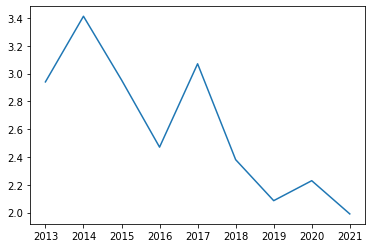

In [208]:
plt.plot(pbr_mean_ry[pbr_mean_ry.Code.isin(pbr_mean_ry[(pbr_mean_ry['ry']==2013)&(pbr_mean_ry['percentile']==9)].Code)].groupby('ry').mean().pbr-kospi_pbr)

In [262]:
pbr_mean_ry[pbr_mean_ry.Code.isin(pbr_mean_ry[(pbr_mean_ry['ry']==2015)&(pbr_mean_ry['percentile']==0)].Code)].groupby('ry').mean()

,pbr,percentile
ry,,
2013,0.489016,1.107692
2014,0.508286,0.538462
2015,0.236761,0.000000
2016,0.400589,0.469697
2017,0.451671,0.787879
2018,0.400211,0.939394
2019,0.302750,1.106061
2020,0.631284,1.545455
2021,0.599609,1.833333


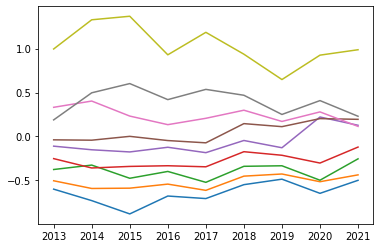

In [256]:
for i in range(9):
    plt.plot(pbr_mean_ry[pbr_mean_ry.Code.isin(pbr_mean_ry[(pbr_mean_ry['ry']==2015)&(pbr_mean_ry['percentile']==i)].Code)].groupby('ry').mean().pbr-kospi_pbr)

In [357]:
pbr_mean_ry[(pbr_mean_ry['ry']==2015)].pbr

2     1.096478
11    3.085837
20    0.741257
29    0.773418
38    1.450880
        ...   
0     0.000000
0     0.000000
0     0.000000
0     0.000000
0     0.000000
Name: pbr, Length: 658, dtype: float64

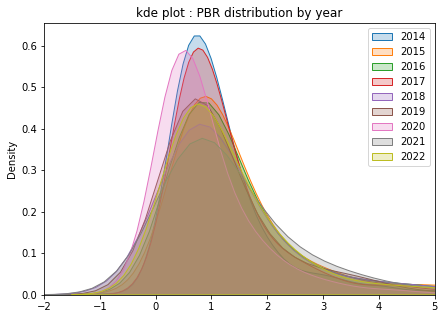

In [43]:
import seaborn as sns

plt.figure(figsize=(7,5))
plt.xlim(-2, 5)
plt.title("kde plot : PBR distribution by year")
for i in range(2013,2022):
    sns.kdeplot(list(pbr_mean_ry[(pbr_mean_ry['ry']==i)].pbr), shade=True)
plt.legend(range(2014,2023))

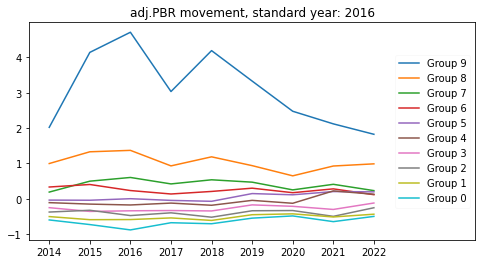

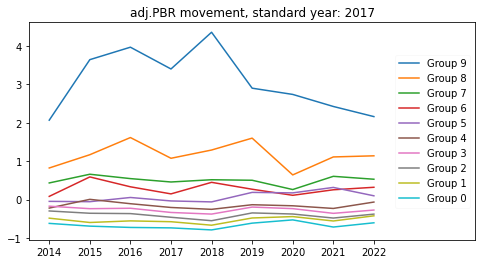

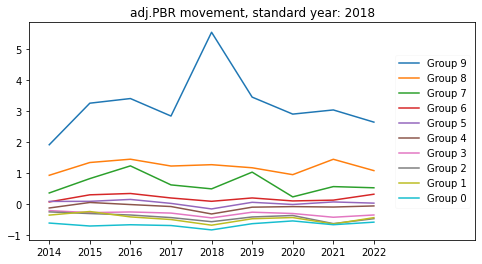

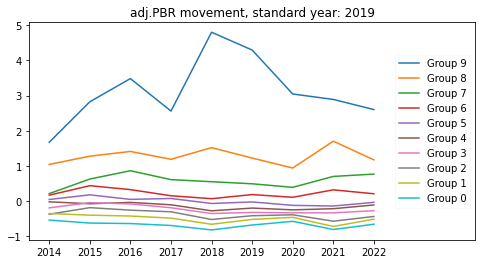

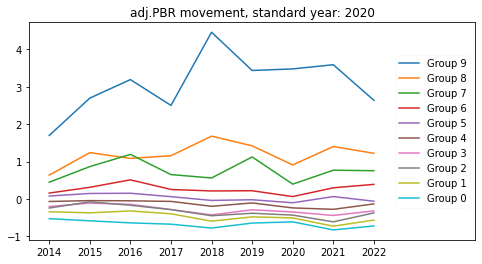

In [44]:

for j in range(2015,2020):
    plt.figure(figsize=(8,4))
    plt.title(f'adj.PBR movement, standard year: {j+1}')
    plt.xticks(range(2013,2022), labels=range(2014,2023))
    plt.xlim([2012.5, 2023.5])
    for i in range(9,-1,-1):
        
        plt.plot(pbr_mean_ry[pbr_mean_ry.Code.isin(pbr_mean_ry[(pbr_mean_ry['ry']==j)&(pbr_mean_ry['percentile']==i)].Code)].groupby('ry').mean().pbr-kospi_pbr)
    
    plt.legend([f"Group {x}" for x in range(9,-1,-1)],fancybox=True, framealpha=0.1,loc=7)

In [45]:
pbr_move = pd.DataFrame(pbr_mean_ry[pbr_mean_ry.Code.isin(pbr_mean_ry[(pbr_mean_ry['ry']==2015)&(pbr_mean_ry['percentile']==i)].Code)].groupby('ry').mean().pbr-kospi_pbr,columns=[i])
pbr_move 
pbr_move['{i}'] = pbr_mean_ry[pbr_mean_ry.Code.isin(pbr_mean_ry[(pbr_mean_ry['ry']==2015)&(pbr_mean_ry['percentile']==i)].Code)].groupby('ry').mean().pbr-kospi_pbr

In [382]:
pbr_move = pd.DataFrame(pbr_mean_ry[pbr_mean_ry.Code.isin(pbr_mean_ry[(pbr_mean_ry['ry']==2015)&(pbr_mean_ry['percentile']==7)].Code)].groupby('ry').mean().pbr-kospi_pbr,columns=['2015'])
for i in range(2015,2020):
    pbr_move[f'{i}'] = pbr_mean_ry[pbr_mean_ry.Code.isin(pbr_mean_ry[(pbr_mean_ry['ry']==i)&(pbr_mean_ry['percentile']==7)].Code)].groupby('ry').mean().pbr-kospi_pbr

In [383]:
pbr_move.to_excel('pbrmove.xlsx')

In [244]:
"plt.plot(pbr_mean_ry[pbr_mean_ry.Code.isin(pbr_mean_ry[(pbr_mean_ry['ry']==2017)&(pbr_mean_ry['percentile']==0)].Code)].groupby('ry').mean().pbr-kospi_pbr)".replace('_ry','_ry2')

"plt.plot(pbr_mean_ry2[pbr_mean_ry2.Code.isin(pbr_mean_ry2[(pbr_mean_ry2['ry']==2017)&(pbr_mean_ry2['percentile']==0)].Code)].groupby('ry').mean().pbr-kospi_pbr)"

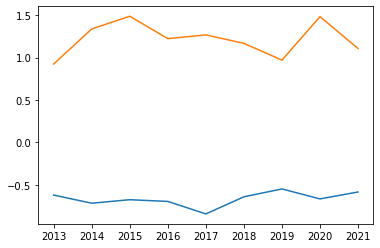

In [220]:
plt.plot(pbr_mean_ry[pbr_mean_ry.Code.isin(pbr_mean_ry[(pbr_mean_ry['ry']==2017)&(pbr_mean_ry['percentile']==0)].Code)].groupby('ry').mean().pbr-kospi_pbr)
plt.plot(pbr_mean_ry[pbr_mean_ry.Code.isin(pbr_mean_ry[(pbr_mean_ry['ry']==2017)&(pbr_mean_ry['percentile']==8)].Code)].groupby('ry').mean().pbr-kospi_pbr)

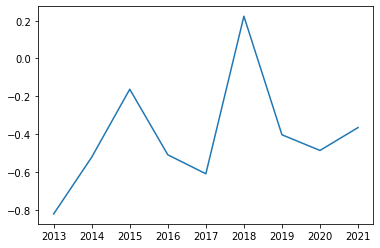

In [249]:
plt.plot(pbr_mean_ry[pbr_mean_ry.Code.isin(pbr_mean_ry[(pbr_mean_ry['ry']==2013)&(pbr_mean_ry['percentile']==0)].Code)].groupby('ry').mean().pbr-kospi_pbr)


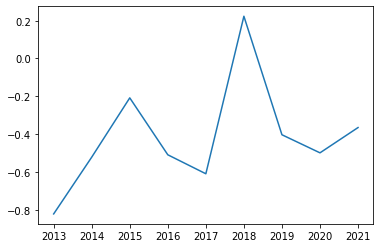

In [250]:
plt.plot(pbr_mean_ry2[pbr_mean_ry2.Code.isin(pbr_mean_ry2[(pbr_mean_ry2['ry']==2013)&(pbr_mean_ry2['percentile']==0)].Code)].groupby('ry').mean().pbr-kospi_pbr)


In [46]:
pbr_mean_ry[(pbr_mean_ry['percentile']==9)&(pbr_mean_ry['ry']==2015)]

,Code,ry,pbr,percentile
380,001060,2015,3.194434,9
479,001360,2015,4.256361,9
523,001440,2015,7.914314,9
656,001800,2015,3.724054,9
665,001820,2015,3.193045,9
...,...,...,...,...
5827,192820,2015,12.442890,9
5834,194370,2015,3.196691,9
5912,214390,2015,3.227851,9
5919,214420,2015,3.378734,9


In [47]:
pbr_mean_ry[pbr_mean_ry.Code.isin(pbr_mean_ry[(pbr_mean_ry['ry']==2015)&(pbr_mean_ry['percentile']==9)].Code)].groupby('ry').mean().pbr

ry
2013    3.111383
2014    5.383594
2015    5.834062
2016    4.115478
2017    5.353794
2018    4.281485
2019    3.266723
2020    3.399783
2021    2.924655
Name: pbr, dtype: float64

In [ ]:
for i in range(10):
plt.plot(pbr_mean_ry[pbr_mean_ry.Code.isin(pbr_mean_ry[(pbr_mean_ry['ry']==2013)&(pbr_mean_ry['percentile']==1)].Code)].groupby('ry').mean().pbr)

In [48]:
len(pricedf_indart.Code.unique())

763

In [304]:
low2013 = list(pbr_mean_ry[(pbr_mean_ry['ry']==2013)&(pbr_mean_ry['percentile']==0)].Code)
low2014 = list(pbr_mean_ry[(pbr_mean_ry['ry']==2014)&(pbr_mean_ry['percentile']==0)].Code)
low2015 = list(pbr_mean_ry[(pbr_mean_ry['ry']==2015)&(pbr_mean_ry['percentile']==0)].Code)
len([val for val in low2013 if val in low2015])

38

In [53]:
group0 = []
for i in range(2013, 2022):
    for j in range(2013,2022):
        group0.append(len([val for val in list(pbr_mean_ry[(pbr_mean_ry['ry']==i)&(pbr_mean_ry['percentile']==0)].Code) if val in list(pbr_mean_ry[(pbr_mean_ry['ry']==j)&(pbr_mean_ry['percentile']==0)].Code)])/len(pbr_mean_ry[(pbr_mean_ry['ry']==i)&(pbr_mean_ry['percentile']==0)].Code))
pd.DataFrame(np.array(group0).reshape(9,9),columns=range(2014,2023),index=range(2014,2023))

,2014,2015,2016,2017,2018,2019,2020,2021,2022
2014,1.000000,0.634921,0.603175,0.492063,0.476190,0.460317,0.380952,0.333333,0.285714
2015,0.625000,1.000000,0.734375,0.640625,0.546875,0.531250,0.484375,0.453125,0.390625
2016,0.575758,0.712121,1.000000,0.757576,0.651515,0.621212,0.545455,0.469697,0.378788
2017,0.462687,0.611940,0.746269,1.000000,0.686567,0.671642,0.597015,0.567164,0.522388
2018,0.428571,0.500000,0.614286,0.657143,1.000000,0.785714,0.728571,0.614286,0.557143
2019,0.402778,0.472222,0.569444,0.625000,0.763889,1.000000,0.791667,0.638889,0.597222
2020,0.333333,0.430556,0.500000,0.555556,0.708333,0.791667,1.000000,0.694444,0.666667
2021,0.283784,0.391892,0.418919,0.513514,0.581081,0.621622,0.675676,1.000000,0.797297
2022,0.236842,0.328947,0.328947,0.460526,0.513158,0.565789,0.631579,0.776316,1.000000


In [395]:
pd.DataFrame(np.array(group0).reshape(9,9),columns=range(2014,2023),index=range(2014,2023)).to_excel('group0prob.xlsx')

In [402]:
group9 = []
for i in range(2013, 2022):
    for j in range(2013,2022):
        
        group9.append(len([val for val in list(pbr_mean_ry[(pbr_mean_ry['ry']==i)&(pbr_mean_ry['percentile']==9)].Code) if val in list(pbr_mean_ry[(pbr_mean_ry['ry']==j)&(pbr_mean_ry['percentile']==9)].Code)])/len(pbr_mean_ry[(pbr_mean_ry['ry']==i)&(pbr_mean_ry['percentile']==9)].Code))
pd.DataFrame(np.array(group9).reshape(9,9),columns=range(2014,2023),index=range(2014,2023)).to_excel('group9prob.xlsx')

In [398]:
pd.DataFrame(np.array(group1).reshape(9,9),columns=range(2014,2023),index=range(2014,2023)).to_excel('group1prob.xlsx')

In [404]:
len(pbr_mean_ry[(pbr_mean_ry['ry']==2013)&(pbr_mean_ry['percentile']==9)].Code)

63

In [54]:
def get_code(year, percent):
    return pbr_mean_ry[(pbr_mean_ry['ry']==year)&(pbr_mean_ry['percentile']==percent)].Code
get_code(2013,0)

27      000070
63      000140
72      000150
207     000590
261     000700
         ...  
4826    071090
5185    092220
5194    092230
5402    104700
5574    128820
Name: Code, Length: 63, dtype: object

In [55]:
pbr0_change_y1 = pd.DataFrame(columns = ['y0','y1'])

for i in range(2013,2021):
    temp_df = pbr_mean_ry[(pbr_mean_ry.Code.isin(get_code(i,0)))&(pbr_mean_ry.ry.isin([i,i+1]))].pivot('Code','ry','pbr')
    temp_df.columns = ['y0','y1']
    pbr0_change_y1 = pd.concat([pbr0_change_y1,temp_df])
pbr0_change_y1 

,y0,y1
000070,0.35528,0.527246
000140,0.252955,0.284912
000150,0.310341,0.283411
000590,0.347781,0.452751
000700,0.374455,1.269652
...,...,...
092230,0.208376,0.192033
093050,0.378547,0.363714
123700,0.392978,0.373078
200880,0.401789,0.261365


In [56]:
pbr0_change_y1 = pbr0_change_y1[pbr0_change_y1['y0']>=-1.5]

In [57]:
pbr0_change_y1.astype('float64')

,y0,y1
000070,0.355280,0.527246
000140,0.252955,0.284912
000150,0.310341,0.283411
000590,0.347781,0.452751
000700,0.374455,1.269652
...,...,...
092230,0.208376,0.192033
093050,0.378547,0.363714
123700,0.392978,0.373078
200880,0.401789,0.261365


In [58]:
adj_pbr = pbr_mean_ry.copy()

for i in range(len(adj_pbr)):
    adj_pbr['pbr'].iloc[i] = adj_pbr.iloc[i]['pbr'] - kospi_pbr.to_dict()[adj_pbr.iloc[i]['ry']]
adj_pbr

/var/folders/p9/ysrl1npn6yg_70klh16w8hn00000gn/T/ipykernel_41307/2546467192.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adj_pbr['pbr'].iloc[i] = adj_pbr.iloc[i]['pbr'] - kospi_pbr.to_dict()[adj_pbr.iloc[i]['ry']]


,Code,ry,pbr,percentile
0,000020,2013,-0.364375,3
1,000020,2014,-0.217184,4
2,000020,2015,-0.023522,5
3,000020,2016,-0.050206,5
4,000020,2017,-0.002131,6
...,...,...,...,...
0,109070,2020,-1.280000,-1
0,109070,2021,-1.100000,-1
0,145210,2017,-1.160000,-1
0,145210,2018,-0.950000,-1


In [59]:
pbr0_change_y1 = pd.DataFrame(columns = ['y0','y1'])

for i in range(2013,2021):
    temp_df = adj_pbr[(adj_pbr.Code.isin(get_code(i,0)))&(adj_pbr.ry.isin([i,i+1]))].pivot('Code','ry','pbr')
    temp_df.columns = ['y0','y1']
    pbr0_change_y1 = pd.concat([pbr0_change_y1,temp_df])
pbr0_change_y1

,y0,y1
000070,-0.73472,-0.712754
000140,-0.837045,-0.955088
000150,-0.779659,-0.956589
000590,-0.742219,-0.787249
000700,-0.715545,0.029652
...,...,...
092230,-1.071624,-0.907967
093050,-0.901453,-0.736286
123700,-0.887022,-0.726922
200880,-0.878211,-0.838635


In [531]:
pbr0_change_y2 = pd.DataFrame(columns = ['y0','y2'])

for i in range(2013,2020):
    temp_df = adj_pbr[(adj_pbr.Code.isin(get_code(i,0)))&(adj_pbr.ry.isin([i,i+2]))].pivot('Code','ry','pbr')
    temp_df.columns = ['y0','y2']
    pbr0_change_y2 = pd.concat([pbr0_change_y2,temp_df])
pbr0_change_y2

,y0,y2
000070,-0.73472,-0.346582
000140,-0.837045,-0.798142
000150,-0.779659,-0.870014
000590,-0.742219,-0.755386
000700,-0.715545,-0.11219
...,...,...
200880,-0.651467,-0.838635
267270,-0.574335,-0.639846
298040,-0.641376,-0.581242
306200,-0.596158,-0.510042


In [567]:
pbr1_change_y1 = pd.DataFrame(columns = ['y0','y1'])

for i in range(2013,2021):
    temp_df = adj_pbr[(adj_pbr.Code.isin(get_code(i,1)))&(adj_pbr.ry.isin([i,i+1]))].pivot('Code','ry','pbr')
    temp_df.columns = ['y0','y1']
    pbr1_change_y1 = pd.concat([pbr1_change_y1,temp_df])
pbr1_change_y1

,y0,y1
000180,-0.604085,-0.469243
000500,-0.630251,-0.80831
000520,-0.610542,-0.533379
000680,-0.634737,-0.777363
000850,-0.578481,-0.566645
...,...,...
145990,-0.831297,-0.708123
183190,-0.743324,-0.433933
267250,-0.849669,-0.720472
282690,-0.84816,-0.628375


In [559]:
pbr1_change_y2 = pd.DataFrame(columns = ['y0','y2'])

for i in range(2013,2020):
    temp_df = adj_pbr[(adj_pbr.Code.isin(get_code(i,1)))&(adj_pbr.ry.isin([i,i+2]))].pivot('Code','ry','pbr')
    temp_df.columns = ['y0','y2']
    pbr1_change_y2 = pd.concat([pbr1_change_y2,temp_df])
pbr1_change_y2.mean()

y0   -0.597978
y2   -0.538870
dtype: float64

In [573]:
pbr0_change_y1.mean()

y0   -0.802761
y1   -0.695870
dtype: float64

In [597]:
pbr0_change_y1.mean()

y0   -0.802761
y1   -0.695870
dtype: float64

In [624]:
y2list = []
for per in range(0,10):
    pbr_change_y2 = pd.DataFrame(columns = ['y0','y2'])
    for i in range(2013,2020):
        temp_df = adj_pbr[(adj_pbr.Code.isin(get_code(i,per)))&(adj_pbr.ry.isin([i,i+2]))].pivot('Code','ry','pbr')
        temp_df.columns = ['y0','y2']
        pbr_change_y2 = pd.concat([pbr_change_y2,temp_df])
    print(per,pbr_change_y2.mean(),sp.stats.ttest_rel(pbr_change_y2.y2,pbr_change_y2.y0),sep='\n')
    y2list.append([per,pbr_change_y2.y2.mean()-pbr_change_y2.y0.mean(),sp.stats.ttest_rel(pbr_change_y2.y2,pbr_change_y2.y0)[0],sp.stats.ttest_rel(pbr_change_y2.y2,pbr_change_y2.y0)[1]])

0
y0   -0.775503
y2   -0.612784
dtype: float64
Ttest_relResult(statistic=2.6700729261876237, pvalue=0.007844528265275517)
1
y0   -0.597978
y2   -0.538870
dtype: float64
Ttest_relResult(statistic=4.6636439231739555, pvalue=4.054683345411523e-06)
2
y0   -0.486307
y2   -0.390584
dtype: float64
Ttest_relResult(statistic=3.8419693863810322, pvalue=0.00013884408807162278)
3
y0   -0.37164
y2   -0.28175
dtype: float64
Ttest_relResult(statistic=4.663638481791874, pvalue=4.052560154812178e-06)
4
y0   -0.238029
y2   -0.138206
dtype: float64
Ttest_relResult(statistic=3.6730939270614984, pvalue=0.0002671216626524824)
5
y0   -0.073354
y2    0.003749
dtype: float64
Ttest_relResult(statistic=2.921830809458784, pvalue=0.0036488703811221198)
6
y0    0.133181
y2    0.252291
dtype: float64
Ttest_relResult(statistic=2.7133552430222267, pvalue=0.006904648786084382)
7
y0    0.470939
y2    0.547480
dtype: float64
Ttest_relResult(statistic=1.406538829915432, pvalue=0.16022642982130256)
8
y0    1.137190
y2    1

In [609]:
y1list=[]

for per in range(0,10):
    pbr_change_y1 = pd.DataFrame(columns = ['y0','y1'])
    for i in range(2013,2021):
        temp_df = adj_pbr[(adj_pbr.Code.isin(get_code(i,per)))&(adj_pbr.ry.isin([i,i+1]))].pivot('Code','ry','pbr')
        temp_df.columns = ['y0','y1']
        pbr_change_y1 = pd.concat([pbr_change_y1,temp_df])
    print(per,pbr_change_y1.y1.mean()-pbr_change_y1.y0.mean(),sp.stats.ttest_rel(pbr_change_y1.y1,pbr_change_y1.y0),sep='\n')
    y1list.append([per,pbr_change_y1.y1.mean()-pbr_change_y1.y0.mean(),sp.stats.ttest_rel(pbr_change_y1.y1,pbr_change_y1.y0)[0],sp.stats.ttest_rel(pbr_change_y1.y1,pbr_change_y1.y0)[1]])

0
0.10689041625129814
Ttest_relResult(statistic=3.4682263566085094, pvalue=0.0005651510228379024)
1
0.054940256133985454
Ttest_relResult(statistic=5.159936739508845, pvalue=3.4695283613056683e-07)
2
0.06537783478742615
Ttest_relResult(statistic=3.6256459053320333, pvalue=0.00031542868896441826)
3
0.056008629141290844
Ttest_relResult(statistic=3.9834286925637654, pvalue=7.717150609322996e-05)
4
0.08037695359286315
Ttest_relResult(statistic=4.349892391678465, pvalue=1.626737340757721e-05)
5
0.062244423370969124
Ttest_relResult(statistic=2.5340128408995843, pvalue=0.011558519286637743)
6
0.09907416507320463
Ttest_relResult(statistic=2.5896965391091653, pvalue=0.009863368533005814)
7
0.15526871779750773
Ttest_relResult(statistic=1.646751080700106, pvalue=0.10018886242292747)
8
0.013770068362210175
Ttest_relResult(statistic=0.2543437055122731, pvalue=0.7993263255551604)
9
-0.8684119990743953
Ttest_relResult(statistic=-4.485741928563176, pvalue=8.86034996962267e-06)


In [620]:
ym1list=[]

for per in range(0,10):
    pbr_change_y1 = pd.DataFrame(columns = ['y0','y1'])
    for i in range(2014,2022):
        temp_df = adj_pbr[(adj_pbr.Code.isin(get_code(i,per)))&(adj_pbr.ry.isin([i,i-1]))].pivot('Code','ry','pbr').dropna()
        temp_df.columns = ['y0','y1']
        pbr_change_y1 = pd.concat([pbr_change_y1,temp_df])
    print(per,pbr_change_y1.y0.mean()-pbr_change_y1.y1.mean(),sp.stats.ttest_rel(pbr_change_y1.y0,pbr_change_y1.y1),sep='\n')
    ym1list.append([per,pbr_change_y1.y0.mean()-pbr_change_y1.y1.mean(),sp.stats.ttest_rel(pbr_change_y1.y0,pbr_change_y1.y1)[0],sp.stats.ttest_rel(pbr_change_y1.y0,pbr_change_y1.y1)[1]])

0
0.07479499443998372
Ttest_relResult(statistic=3.620129408391172, pvalue=0.00032130201242828207)
1
0.06150360691792289
Ttest_relResult(statistic=5.468451478963548, pvalue=6.878537065925286e-08)
2
0.07865517471963701
Ttest_relResult(statistic=4.1987782882618925, pvalue=3.1305949233856766e-05)
3
0.08581838054278201
Ttest_relResult(statistic=6.420422465878362, pvalue=2.9397255299858184e-10)
4
0.08425984573325809
Ttest_relResult(statistic=5.77865834656158, pvalue=1.2630559588524e-08)
5
0.036015213256519484
Ttest_relResult(statistic=2.4104380780317336, pvalue=0.01626776636754331)
6
0.06276342728369877
Ttest_relResult(statistic=2.5460205884598532, pvalue=0.011171514141745493)
7
0.13008406244041604
Ttest_relResult(statistic=1.5860065047771423, pvalue=0.11332978734928568)
8
0.14665552431967277
Ttest_relResult(statistic=1.875773677548086, pvalue=0.06123476633030358)
9
-0.8306802683084342
Ttest_relResult(statistic=-4.094976690290384, pvalue=4.893731247853716e-05)


In [622]:
ym2list=[]

for per in range(0,10):
    pbr_change_y1 = pd.DataFrame(columns = ['y0','y1'])
    for i in range(2015,2022):
        temp_df = adj_pbr[(adj_pbr.Code.isin(get_code(i,per)))&(adj_pbr.ry.isin([i,i-2]))].pivot('Code','ry','pbr').dropna()
        temp_df.columns = ['y0','y1']
        pbr_change_y1 = pd.concat([pbr_change_y1,temp_df])
    print(per,pbr_change_y1.y0.mean()-pbr_change_y1.y1.mean(),sp.stats.ttest_rel(pbr_change_y1.y0,pbr_change_y1.y1),sep='\n')
    ym2list.append([per,pbr_change_y1.y0.mean()-pbr_change_y1.y1.mean(),sp.stats.ttest_rel(pbr_change_y1.y0,pbr_change_y1.y1)[0],sp.stats.ttest_rel(pbr_change_y1.y0,pbr_change_y1.y1)[1]])

0
0.14027359695456643
Ttest_relResult(statistic=5.4182538669633775, pvalue=9.46231519698155e-08)
1
0.12818034385297083
Ttest_relResult(statistic=8.938008733335728, pvalue=8.08402815645625e-18)
2
0.14759967298716997
Ttest_relResult(statistic=8.265003820460086, pvalue=1.3887203224936234e-15)
3
0.13878102942999548
Ttest_relResult(statistic=8.180156489577055, pvalue=2.570547953188516e-15)
4
0.15375841710531518
Ttest_relResult(statistic=5.7787742807860685, pvalue=1.3617279958967125e-08)
5
0.09297763229507512
Ttest_relResult(statistic=4.277071174266135, pvalue=2.3015831484002506e-05)
6
0.15467103487669617
Ttest_relResult(statistic=3.6239193254560997, pvalue=0.0003221727012711696)
7
0.19769031869818599
Ttest_relResult(statistic=1.8360583702631044, pvalue=0.06699848585782114)
8
0.037161326604441935
Ttest_relResult(statistic=0.5224163026345896, pvalue=0.6016410606241562)
9
-1.2815345245784213
Ttest_relResult(statistic=-5.598691935366431, pvalue=3.793775088705905e-08)


In [623]:
pd.DataFrame(ym2list).to_excel('ym2list.xlsx')

In [579]:
sp.stats.ttest_rel(pbr1_change_y2.y2,pbr1_change_y2.y0)[0]

4.6636439231739555

In [568]:
print(sp.stats.ttest_rel(pbr0_change_y1.y1,pbr0_change_y1.y0),
sp.stats.ttest_rel(pbr0_change_y2.y2,pbr0_change_y2.y0),
sp.stats.ttest_rel(pbr1_change_y1.y1,pbr1_change_y1.y0),
sp.stats.ttest_rel(pbr1_change_y2.y2,pbr1_change_y2.y0),sep='\n')


Ttest_relResult(statistic=3.4682263566085094, pvalue=0.0005651510228379024)
Ttest_relResult(statistic=2.6700729261876237, pvalue=0.007844528265275517)
Ttest_relResult(statistic=5.159936739508845, pvalue=3.4695283613056683e-07)
Ttest_relResult(statistic=4.6636439231739555, pvalue=4.054683345411523e-06)


In [572]:
sp.stats.ttest_rel(pbr8_change_y1.y1,pbr8_change_y1.y0)

Ttest_relResult(statistic=0.869022069465539, pvalue=0.3852786090481978)

In [540]:
pbr8_change_y1 = pd.DataFrame(columns = ['y0','y1'])

for i in range(2013,2020):
    temp_df = adj_pbr[(adj_pbr.Code.isin(get_code(i,8)))&(adj_pbr.ry.isin([i,i+1]))].pivot('Code','ry','pbr')
    temp_df.columns = ['y0','y1']
    pbr8_change_y1 = pd.concat([pbr8_change_y1,temp_df])
pbr8_change_y1

,y0,y1
000100,0.552872,0.610346
000660,0.997955,0.568637
001360,0.509216,8.027917
001550,0.587963,0.586483
001680,0.88756,0.768133
...,...,...
272450,0.868822,7.406248
284740,0.937585,0.505177
293480,0.836569,0.473122
298690,0.950779,1.42548


In [ ]:
pbr8_change_y2 = pd.DataFrame(columns = ['y0','y2'])

for i in range(2013,2020):
    temp_df = adj_pbr[(adj_pbr.Code.isin(get_code(i,8)))&(adj_pbr.ry.isin([i,i+1]))].pivot('Code','ry','pbr')
    temp_df.columns = ['y0','y1']
    pbr8_change_y1 = pd.concat([pbr8_change_y1,temp_df])
pbr8_change_y1

(-2.0, 1.0)

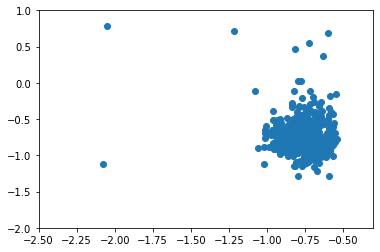

In [550]:
plt.scatter(pbr0_change_y2.y0,pbr0_change_y2.y2)
plt.xlim((-2.5,-.3))
plt.ylim((-2,1))

In [507]:
pbr0_change_y1.y0.mean()-pbr0_change_y1.y1.mean()

-0.10689041625129814

In [530]:
# group0 Y+1
sp.stats.ttest_1samp(pbr0_change_y1.y1,popmean=pbr0_change_y1.y0.mean())

Ttest_1sampResult(statistic=4.4919815002371575, pvalue=8.613617053141146e-06)

In [615]:
sp.stats.ttest_rel(pbr1_change_y1.y1,pbr1_change_y1.y0)

Ttest_relResult(statistic=5.159936739508845, pvalue=3.4695283613056683e-07)

In [514]:
import scipy as sp

In [532]:
sp.stats.ttest_1samp(pbr0_change_y2.y2,popmean=pbr0_change_y2.y0.mean())

Ttest_1sampResult(statistic=2.916610229815833, pvalue=0.0037068073962222142)

In [538]:
sp.stats.ttest_1samp(pbr1_change_y1.y1,popmean=pbr1_change_y1.y0.mean())

Ttest_1sampResult(statistic=3.010147375162974, pvalue=0.0027516689157315068)

In [541]:
sp.stats.ttest_1samp(pbr8_change_y1.y1,popmean=pbr8_change_y1.y0.mean())

Ttest_1sampResult(statistic=0.8806291124275546, pvalue=0.37896867453479266)

### 시가총액 검정

In [627]:
pricedf_indart

,Unnamed: 0,Date,Code,Name,Market,Dept,Close,ChangeCode,Changes,ChagesRatio,...,High,Low,Volume,Amount,Marcap,Stocks,MarketId,Rank,pbr,ry
0,0,2014-03-17,005930,삼성전자,KOSPI,NaN,1266000,2,-9000,-0.71,...,1276000,1258000,176400,223045315000,186480960642000,147299337,STK,1,1.243074,2013
1,1,2014-03-17,005380,현대차,KOSPI,NaN,234000,1,5000,2.18,...,234000,229000,334656,77783013500,51544696086000,220276479,STK,2,0.910961,2013
2,2,2014-03-17,012330,현대모비스,KOSPI,NaN,301000,1,5000,1.69,...,303500,294500,105594,31789696000,29300502763000,97343863,STK,3,1.451009,2013
3,3,2014-03-17,035420,NAVER,KOSPI,NaN,801000,2,-9000,-1.11,...,822000,792000,131136,105096454000,26403105879000,32962679,STK,4,17.896661,2013
4,4,2014-03-17,000660,SK하이닉스,KOSPI,NaN,36700,2,-1250,-3.29,...,37450,36600,4053729,149309687150,26064372699700,710200891,STK,5,1.994693,2013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1469550,1892635,2022-11-02,001210,금호전기,KOSPI,NaN,1005,1,5,0.50,...,1015,999,22304,22373198,27691961955,27554191,STK,2415,1.508062,2021
1469551,1892636,2022-11-02,025890,한국주강,KOSPI,NaN,2435,1,10,0.41,...,2465,2405,27220,66300610,27538045665,11309259,STK,2419,0.981332,2021
1469552,1892638,2022-11-02,071950,코아스,KOSPI,NaN,799,3,0,0.00,...,809,773,19668,15529923,24694860790,30907210,STK,2436,1.296995,2021
1469553,1892639,2022-11-02,008500,일정실업,KOSPI,NaN,20450,1,50,0.25,...,21050,19400,2049,41640500,24540000000,1200000,STK,2437,1.321419,2021


In [60]:
mcap_mean_ry = pricedf_indart[pricedf_indart['Date'].map(lambda x: x.month)==4].groupby(['Code','ry']).mean().Marcap.reset_index(drop=False)
mcap_mean_ry

,Code,ry,Marcap
0,000020,2013,1.648845e+11
1,000020,2014,2.349671e+11
2,000020,2015,2.523189e+11
3,000020,2016,2.604610e+11
4,000020,2017,3.438231e+11
...,...,...,...
6193,900140,2019,2.394226e+11
6194,900140,2020,3.523788e+11
6195,900140,2021,3.478331e+11
6196,950210,2020,1.865986e+12


In [61]:
kospi_value = pd.read_excel('kospi_value.xlsx')
kospi_value.index=kospi_value.year
kospi_dict = kospi_value.drop('year',axis=1).to_dict()['kospi']

In [62]:
for i in mcap_mean_ry.Code.unique():
    for j in range(mcap_mean_ry[mcap_mean_ry['Code']==i].iloc[0].ry,2022):
        if len(mcap_mean_ry[(mcap_mean_ry['Code']==i)&(mcap_mean_ry['ry']==j)])==0:
            mcap_mean_ry= pd.concat([mcap_mean_ry,pd.DataFrame([[i,j,0]],columns = mcap_mean_ry.columns)])

mcap_mean_ry

,Code,ry,Marcap
0,000020,2013,1.648845e+11
1,000020,2014,2.349671e+11
2,000020,2015,2.523189e+11
3,000020,2016,2.604610e+11
4,000020,2017,3.438231e+11
...,...,...,...
0,109070,2020,0.000000e+00
0,109070,2021,0.000000e+00
0,145210,2017,0.000000e+00
0,145210,2018,0.000000e+00


In [65]:
# mcap 변경 확인
pbr0_cap_change_y1 = pd.DataFrame(columns = ['y0','y1','y'])

for i in range(2013,2021):
    temp_df = mcap_mean_ry[(mcap_mean_ry.Code.isin(get_code(i,0)))&(mcap_mean_ry.ry.isin([i,i+1]))].pivot('Code','ry','Marcap')
    temp_df['y'] = pd.Series([i]*len(temp_df), index = temp_df.index)
    temp_df.columns = ['y0','y1','y']
    pbr0_cap_change_y1 = pd.concat([pbr0_cap_change_y1,temp_df])
pbr0_cap_change_y1['y1'] = pbr0_cap_change_y1['y1']/pbr0_cap_change_y1['y0']
pbr0_cap_change_y1['y0'] = pbr0_cap_change_y1['y0']/pbr0_cap_change_y1['y0']
pbr0_cap_change_y1['y1'] = pbr0_cap_change_y1['y1'] - pbr0_cap_change_y1['y'].map(lambda x: (kospi_dict[x+1]/kospi_dict[x])-1)
pbr0_cap_change_y1

,y0,y1,y
000070,1.0,1.396314,2013
000140,1.0,0.910985,2013
000150,1.0,0.81323,2013
000590,1.0,1.34903,2013
000700,1.0,0.957267,2013
...,...,...,...
092230,1.0,1.087968,2020
093050,1.0,1.16169,2020
123700,1.0,1.17976,2020
200880,1.0,0.861941,2020


In [91]:
pbr9_cap_change_y1 = pd.DataFrame(columns = ['y0','y1','y'])

for i in range(2013,2021):
    temp_df = mcap_mean_ry[(mcap_mean_ry.Code.isin(get_code(i,9)))&(mcap_mean_ry.ry.isin([i,i+1]))].pivot('Code','ry','Marcap')
    temp_df['y'] = pd.Series([i]*len(temp_df), index = temp_df.index)
    temp_df.columns = ['y0','y1','y']
    pbr9_cap_change_y1 = pd.concat([pbr9_cap_change_y1,temp_df])
pbr9_cap_change_y1

,y0,y1,y
000040,132295343229.636368,195643629219.545441,2013
001260,73842342696.818176,53545112390.0,2013
001800,4738560984090.90918,7484508446545.454102,2013
002700,108167986332.954544,119231057795.454544,2013
002780,146218417842.954559,392050152505.227295,2013
...,...,...,...
326030,8710569215909.09082,6916178735714.286133,2020
336260,3265606487986.36377,2474571280700.0,2020
352820,8928609665454.544922,11619317142547.619141,2020
365550,895108279090.909058,1508974532857.142822,2020


In [67]:
pbr0_cap_change_y1.y1.mean()

1.123303245054224

In [70]:
sp.stats.ttest_1samp(list(pbr0_cap_change_y1.y1),popmean=1)

Ttest_1sampResult(statistic=4.6211882507779825, pvalue=4.763811799958047e-06)

In [85]:
pbr_cap_change_y1

,y0,y1,y
000040,1.0,1.394539,2013
001260,1.0,0.640827,2013
001800,1.0,1.495189,2013
002700,1.0,1.017976,2013
002780,1.0,2.596963,2013
...,...,...,...
326030,1.0,0.937845,2020
336260,1.0,0.901615,2020
352820,1.0,1.445205,2020
365550,1.0,1.829648,2020


In [87]:
get_code(2013,9)

9       000040
459     001260
654     001800
911     002700
947     002780
         ...  
5583    128940
5745    161890
5800    185750
5825    192820
6187    900140
Name: Code, Length: 63, dtype: object

In [ ]:
y

In [88]:
pbr_cap_change_y1['y'].map(lambda x: (kospi_dict[x+1]/kospi_dict[x])-1)

000040    0.084301
001260    0.084301
001800    0.084301
002700    0.084301
002780    0.084301
            ...   
326030   -0.143847
336260   -0.143847
352820   -0.143847
365550   -0.143847
950210   -0.143847
Name: y, Length: 548, dtype: float64

In [119]:
y1list=[]

for per in range(0,10):
    pbr_cap_change_y1 = pd.DataFrame(columns = ['y0','y1','y'])
    for i in range(2013,2021):
        temp_df = mcap_mean_ry[(mcap_mean_ry.Code.isin(get_code(i,per)))&(mcap_mean_ry.ry.isin([i,i+1]))].pivot('Code','ry','Marcap')
        temp_df['y'] = pd.Series([i]*len(temp_df), index = temp_df.index)
        temp_df.columns = ['y0','y1','y']
        pbr_cap_change_y1 = pd.concat([pbr_cap_change_y1,temp_df])
    pbr_cap_change_y1['y1'] = pbr_cap_change_y1['y1']/pbr_cap_change_y1['y0']
    pbr_cap_change_y1['y0'] = pbr_cap_change_y1['y0']/pbr_cap_change_y1['y0']
    pbr_cap_change_y1['y1'] = pbr_cap_change_y1['y1'] - pbr_cap_change_y1['y'].map(lambda x: (kospi_dict[x+1]/kospi_dict[x])-1)

    
    print(per,pbr_cap_change_y1.y1.mean()-pbr_cap_change_y1.y0.mean(),sp.stats.ttest_1samp(pbr_cap_change_y1.y1,popmean=1),sep='\n')
    y1list.append([per,pbr_cap_change_y1.y1.mean()-pbr_cap_change_y1.y0.mean(),sp.stats.ttest_1samp(pbr_cap_change_y1.y1,popmean=1)[0],sp.stats.ttest_1samp(pbr_cap_change_y1.y1,popmean=1)[1]])

0
0.12330324505422396
Ttest_1sampResult(statistic=4.621188250777965, pvalue=4.763811799958455e-06)
1
0.1227920669370346
Ttest_1sampResult(statistic=5.785637114619412, pvalue=1.2213342775574564e-08)
2
0.11747493834187717
Ttest_1sampResult(statistic=3.392431403562614, pvalue=0.0007433402996853843)
3
0.09575796236588063
Ttest_1sampResult(statistic=4.281722617143856, pvalue=2.1923109684283943e-05)
4
0.12307331791369358
Ttest_1sampResult(statistic=4.997398164347726, pvalue=7.845791818939556e-07)
5
0.0832789361884414
Ttest_1sampResult(statistic=3.310584459450819, pvalue=0.0009933156488788606)
6
0.14070687805845639
Ttest_1sampResult(statistic=3.2028085734934844, pvalue=0.0014405529819354482)
7
0.15794026416474694
Ttest_1sampResult(statistic=2.0540749612269518, pvalue=0.04044750490256541)
8
0.09023657265280627
Ttest_1sampResult(statistic=3.1877085500994986, pvalue=0.0015166106316698484)
9
0.08841522706527694
Ttest_1sampResult(statistic=2.3686737782568414, pvalue=0.01819848529753588)


In [120]:
kospi_value

,year,kospi
year,,
2013,2013,1961.79
2014,2014,2127.17
2015,2015,1994.15
2016,2016,2205.44
2017,2017,2515.38
2018,2018,2203.59
2019,2019,1947.56
2020,2020,3147.86
2021,2021,2695.05


In [121]:
y2list=[]

for per in range(0,10):
    pbr_cap_change_y2 = pd.DataFrame(columns = ['y0','y2','y'])
    for i in range(2013,2020):
        temp_df = mcap_mean_ry[(mcap_mean_ry.Code.isin(get_code(i,per)))&(mcap_mean_ry.ry.isin([i,i+2]))].pivot('Code','ry','Marcap')
        temp_df['y'] = pd.Series([i]*len(temp_df), index = temp_df.index)
        temp_df.columns = ['y0','y2','y']
        pbr_cap_change_y2 = pd.concat([pbr_cap_change_y2,temp_df])
    pbr_cap_change_y2['y2'] = pbr_cap_change_y2['y2']/pbr_cap_change_y2['y0']
    pbr_cap_change_y2['y0'] = pbr_cap_change_y2['y0']/pbr_cap_change_y2['y0']
    pbr_cap_change_y2['y2'] = pbr_cap_change_y2['y2'] - pbr_cap_change_y2['y'].map(lambda x: (kospi_dict[x+2]/kospi_dict[x])-1)

    
    print(per,pbr_cap_change_y2.y2.mean()-pbr_cap_change_y2.y0.mean(),sp.stats.ttest_1samp(pbr_cap_change_y2.y2,popmean=1),sep='\n')
    y2list.append([per,pbr_cap_change_y2.y2.mean()-pbr_cap_change_y2.y0.mean(),sp.stats.ttest_1samp(pbr_cap_change_y2.y2,popmean=1)[0],sp.stats.ttest_1samp(pbr_cap_change_y2.y2,popmean=1)[1]])

0
0.17138943023317732
Ttest_1sampResult(statistic=3.8844078801250728, pvalue=0.00011719395993505727)
1
0.1286054708147264
Ttest_1sampResult(statistic=4.291958739716012, pvalue=2.1518617529196384e-05)
2
0.17593890976220106
Ttest_1sampResult(statistic=3.7703777246170067, pvalue=0.00018381728923303278)
3
0.18667383832486606
Ttest_1sampResult(statistic=4.973179220770118, pvalue=9.243638427620257e-07)
4
0.1743237714650432
Ttest_1sampResult(statistic=4.0179235815385725, pvalue=6.833455307691567e-05)
5
0.12855462355534142
Ttest_1sampResult(statistic=3.6971645502835955, pvalue=0.00024396700494790294)
6
0.1960788005435541
Ttest_1sampResult(statistic=3.322692289273276, pvalue=0.000960956418650072)
7
0.14870554122913804
Ttest_1sampResult(statistic=3.044674036067267, pvalue=0.00246034641777853)
8
0.19835612316729723
Ttest_1sampResult(statistic=3.6486479703591597, pvalue=0.000293151320253425)
9
0.1003277801089304
Ttest_1sampResult(statistic=1.8913968976957962, pvalue=0.059182074587709486)


In [122]:
ym2list=[]

for per in range(0,10):
    pbr_cap_change_y2 = pd.DataFrame(columns = ['y2','y0','y'])
    for i in range(2015,2022):
        temp_df = mcap_mean_ry[(mcap_mean_ry.Code.isin(get_code(i,per)))&(mcap_mean_ry.ry.isin([i,i-2]))].pivot('Code','ry','Marcap').dropna()
        temp_df['y'] = pd.Series([i]*len(temp_df), index = temp_df.index)
        temp_df.columns = ['y2','y0','y']
        pbr_cap_change_y2 = pd.concat([pbr_cap_change_y2,temp_df])
    pbr_cap_change_y2['y2'] = pbr_cap_change_y2['y2']/pbr_cap_change_y2['y0']
    pbr_cap_change_y2['y0'] = pbr_cap_change_y2['y0']/pbr_cap_change_y2['y0']
    pbr_cap_change_y2['y2'] = pbr_cap_change_y2['y2'] - pbr_cap_change_y2['y'].map(lambda x: (kospi_dict[x-2]/kospi_dict[x])-1)

    
    print(per,pbr_cap_change_y2.y2.mean()-pbr_cap_change_y2.y0.mean(),sp.stats.ttest_1samp(pbr_cap_change_y2.y2,popmean=1),sep='\n')
    ym2list.append([per,pbr_cap_change_y2.y2.mean()-pbr_cap_change_y2.y0.mean(),sp.stats.ttest_1samp(pbr_cap_change_y2.y2,popmean=1)[0],sp.stats.ttest_1samp(pbr_cap_change_y2.y2,popmean=1)[1]])

0
0.37417756834238514
Ttest_1sampResult(statistic=14.729078074885056, pvalue=6.648596758171463e-41)
1
0.29152685835691017
Ttest_1sampResult(statistic=13.87736513846279, pvalue=3.6257142810758153e-37)
2
0.2645669908546504
Ttest_1sampResult(statistic=10.384785913475211, pvalue=6.441426341194861e-23)
3
0.17728516698658536
Ttest_1sampResult(statistic=9.240468762408304, pvalue=8.026262257369816e-19)
4
0.1655509261784418
Ttest_1sampResult(statistic=6.190348956547854, pvalue=1.2971589841899662e-09)
5
0.0981007395737512
Ttest_1sampResult(statistic=4.329131368726474, pvalue=1.836028728122092e-05)
6
0.06029221399555751
Ttest_1sampResult(statistic=1.901365946333739, pvalue=0.05787196674731625)
7
-0.007438860110593026
Ttest_1sampResult(statistic=-0.32604412358813983, pvalue=0.7445402174549417)
8
-0.02938728750188402
Ttest_1sampResult(statistic=-1.106691556532372, pvalue=0.2690265388959638)
9
-0.1580360507106593
Ttest_1sampResult(statistic=-6.6280321152162225, pvalue=9.906733659008015e-11)


In [123]:
ym1list=[]

for per in range(0,10):
    pbr_cap_change_y1 = pd.DataFrame(columns = ['y1','y0','y'])
    for i in range(2014,2022):
        temp_df = mcap_mean_ry[(mcap_mean_ry.Code.isin(get_code(i,per)))&(mcap_mean_ry.ry.isin([i,i-1]))].pivot('Code','ry','Marcap').dropna()
        temp_df['y'] = pd.Series([i]*len(temp_df), index = temp_df.index)
        temp_df.columns = ['y1','y0','y']
        pbr_cap_change_y1 = pd.concat([pbr_cap_change_y1,temp_df])
    pbr_cap_change_y1['y1'] = pbr_cap_change_y1['y1']/pbr_cap_change_y1['y0']
    pbr_cap_change_y1['y0'] = pbr_cap_change_y1['y0']/pbr_cap_change_y1['y0']
    pbr_cap_change_y1['y1'] = pbr_cap_change_y1['y1'] - pbr_cap_change_y1['y'].map(lambda x: (kospi_dict[x-1]/kospi_dict[x])-1)

    
    print(per,pbr_cap_change_y1.y1.mean()-pbr_cap_change_y1.y0.mean(),sp.stats.ttest_1samp(pbr_cap_change_y1.y1,popmean=1),sep='\n')
    ym1list.append([per,pbr_cap_change_y1.y1.mean()-pbr_cap_change_y1.y0.mean(),sp.stats.ttest_1samp(pbr_cap_change_y1.y1,popmean=1)[0],sp.stats.ttest_1samp(pbr_cap_change_y1.y1,popmean=1)[1]])

0
0.16725381529963834
Ttest_1sampResult(statistic=11.153497481438984, pvalue=3.256753599425284e-26)
1
0.1323543671404901
Ttest_1sampResult(statistic=9.532556952792428, pvalue=4.779215918234996e-20)
2
0.11934061477487501
Ttest_1sampResult(statistic=8.684252172206442, pvalue=4.368625584458527e-17)
3
0.10709537195075214
Ttest_1sampResult(statistic=7.046899312798812, pvalue=5.49898560002531e-12)
4
0.08653240186047673
Ttest_1sampResult(statistic=4.511567505898646, pvalue=7.875490841463828e-06)
5
0.01654303868958973
Ttest_1sampResult(statistic=1.150257925350179, pvalue=0.25054867418780385)
6
0.011768615705225915
Ttest_1sampResult(statistic=0.6042921499852529, pvalue=0.5459022851147134)
7
-0.009308676118663484
Ttest_1sampResult(statistic=-0.5292675493151036, pvalue=0.5968398055096003)
8
-0.03110784604536254
Ttest_1sampResult(statistic=-1.760090810449872, pvalue=0.0789681256860672)
9
-0.10900391845840918
Ttest_1sampResult(statistic=-5.261733150077384, pvalue=2.0883838376164826e-07)


In [76]:
pd

<module 'pandas' from '/opt/homebrew/lib/python3.9/site-packages/pandas/__init__.py'>

In [124]:
pd.DataFrame(y1list).to_excel('y1listmcap.xlsx')
pd.DataFrame(y2list).to_excel('y2listmcap.xlsx')
pd.DataFrame(ym1list).to_excel('ym1listmcap.xlsx')
pd.DataFrame(ym2list).to_excel('ym2listmcap.xlsx')

### 자본총계 검정

In [626]:
caplist[caplist.code.isin(get_code(2013,0))]

,code,year,fs_nm,cap_amount
24,000070,2013.0,연결재무제표,1658209000000.0
25,000070,2014.0,연결재무제표,1654390000000.0
26,000070,2015.0,연결재무제표,1796363000000.0
27,000070,2016.0,연결재무제표,1850632000000.0
28,000070,2017.0,연결재무제표,1930015000000.0
...,...,...,...,...
6261,104700,2017.0,재무제표,718280670929.0
6262,104700,2018.0,재무제표,717250259351.0
6263,104700,2019.0,재무제표,724936548930.0
6264,104700,2020.0,재무제표,696830670516.0


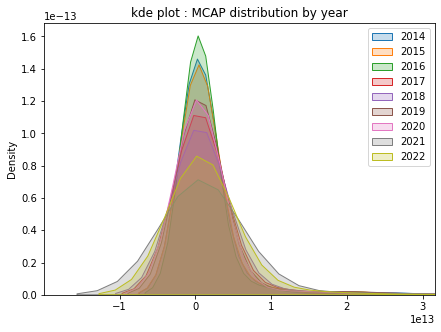

In [144]:
import seaborn as sns

plt.figure(figsize=(7,5))
plt.xlim(-10**13.3, 10**13.5)
plt.title("kde plot : MCAP distribution by year")
for i in range(2013,2022):
    sns.kdeplot(list(mcap_mean_ry[(mcap_mean_ry['ry']==i)].Marcap), shade=True)
plt.legend(range(2014,2023))

In [145]:
kospi_value

,year,kospi
year,,
2013,2013,1961.79
2014,2014,2127.17
2015,2015,1994.15
2016,2016,2205.44
2017,2017,2515.38
2018,2018,2203.59
2019,2019,1947.56
2020,2020,3147.86
2021,2021,2695.05


In [164]:
caplist2 = caplist.copy()
caplist2.columns = ['Code','ry','fs_nm','bv']
caplist2['ry'] = caplist2['ry'].map(int)

In [196]:
for i in caplist2.Code.unique():
    for j in range(caplist2[caplist2['Code']==i].iloc[0].ry,2022):
        if len(caplist2[(caplist2['Code']==i)&(caplist2['ry']==j)])==0:
            caplist2= pd.concat([caplist2,pd.DataFrame([[i,j,'공시안함',1]],columns = caplist2.columns)])
bv_mean_ry = caplist2.copy()[caplist2['Code']!='375500']
caplist2


,Code,ry,fs_nm,bv
0,000020,2016,연결재무제표,252925299902.0
1,000020,2017,연결재무제표,296944728429.0
2,000020,2018,연결재무제표,297400651562.0
3,000020,2019,연결재무제표,300874594398.0
4,000020,2020,연결재무제표,342682240439.0
...,...,...,...,...
6418,381970,2019,재무제표,148367809236.0
6419,381970,2020,재무제표,170965882954.0
6420,381970,2021,재무제표,275472387284.0
6421,383800,2021,재무제표,1414669000000.0


In [197]:
y1list=[]

for per in range(0,10):
    pbr_cap_change_y1 = pd.DataFrame(columns = ['y0','y1','y'])
    for i in range(2013,2021):
        temp_df = bv_mean_ry[(bv_mean_ry.Code.isin(get_code(i,per)))&(bv_mean_ry.ry.isin([i,i+1]))].pivot('Code','ry','bv').dropna()
        temp_df['y'] = pd.Series([i]*len(temp_df), index = temp_df.index)
        temp_df.columns = ['y0','y1','y']
        pbr_cap_change_y1 = pd.concat([pbr_cap_change_y1,temp_df])
    pbr_cap_change_y1['y1'] = pbr_cap_change_y1['y1']/pbr_cap_change_y1['y0']
    pbr_cap_change_y1['y0'] = pbr_cap_change_y1['y0']/pbr_cap_change_y1['y0']
    

    
    print(per,pbr_cap_change_y1.y1.mean()-pbr_cap_change_y1.y0.mean(),sp.stats.ttest_1samp(pbr_cap_change_y1.y1,popmean=1),sep='\n')
    y1list.append([per,pbr_cap_change_y1.y1.mean()-pbr_cap_change_y1.y0.mean(),sp.stats.ttest_1samp(pbr_cap_change_y1.y1,popmean=1)[0],sp.stats.ttest_1samp(pbr_cap_change_y1.y1,popmean=1)[1]])

0
-0.014100201483989161
Ttest_1sampResult(statistic=-1.110307274576809, pvalue=0.26735447878253266)
1
0.029241752741748783
Ttest_1sampResult(statistic=5.148581140774463, pvalue=3.6758263975387674e-07)
2
0.019910127707983616
Ttest_1sampResult(statistic=2.9564239939156427, pvalue=0.0032480939242010534)
3
0.039291172597736734
Ttest_1sampResult(statistic=5.714751988168251, pvalue=1.8116421212380882e-08)
4
0.06500813830110985
Ttest_1sampResult(statistic=5.474752781628882, pvalue=6.69978506358116e-08)
5
0.05875564385370091
Ttest_1sampResult(statistic=3.9429669801009233, pvalue=9.109659190271353e-05)
6
0.06491019924715813
Ttest_1sampResult(statistic=4.31483762218006, pvalue=1.8974492542539582e-05)
7
0.11089325503232783
Ttest_1sampResult(statistic=6.833697752189327, pvalue=2.2366862466502828e-11)
8
0.15463797610575547
Ttest_1sampResult(statistic=9.071527628320856, pvalue=2.1540258948850974e-18)
9
0.6606233830582138
Ttest_1sampResult(statistic=2.5203405719309817, pvalue=0.01200808114698156)


In [188]:
y2list=[]

for per in range(0,10):
    pbr_cap_change_y2 = pd.DataFrame(columns = ['y0','y2','y'])
    for i in range(2013,2020):
        temp_df = bv_mean_ry[(bv_mean_ry.Code.isin(get_code(i,per)))&(bv_mean_ry.ry.isin([i,i+2]))].pivot('Code','ry','bv').dropna()
        temp_df['y'] = pd.Series([i]*len(temp_df), index = temp_df.index)
        temp_df.columns = ['y0','y2','y']
        pbr_cap_change_y2 = pd.concat([pbr_cap_change_y2,temp_df])
    pbr_cap_change_y2['y2'] = pbr_cap_change_y2['y2']/pbr_cap_change_y2['y0']
    pbr_cap_change_y2['y0'] = pbr_cap_change_y2['y0']/pbr_cap_change_y2['y0']
    

    
    print(per,pbr_cap_change_y2.y2.mean()-pbr_cap_change_y2.y0.mean(),sp.stats.ttest_1samp(pbr_cap_change_y2.y2,popmean=1),sep='\n')
    y2list.append([per,pbr_cap_change_y2.y2.mean()-pbr_cap_change_y2.y0.mean(),sp.stats.ttest_1samp(pbr_cap_change_y2.y2,popmean=1)[0],sp.stats.ttest_1samp(pbr_cap_change_y2.y2,popmean=1)[1]])

0
-0.009537099018529505
Ttest_1sampResult(statistic=-0.5693090058621958, pvalue=0.5694167024594596)
1
0.05695548336346534
Ttest_1sampResult(statistic=5.81589959452177, pvalue=1.1157031638674201e-08)
2
0.07368257464526273
Ttest_1sampResult(statistic=6.401746861516415, pvalue=3.732236469451381e-10)
3
0.10170346351527848
Ttest_1sampResult(statistic=9.321664895743327, pvalue=4.44367854393561e-19)
4
0.10980644998632738
Ttest_1sampResult(statistic=6.816132274686696, pvalue=2.8724354133354506e-11)
5
0.13435416216946527
Ttest_1sampResult(statistic=10.638232381564919, pvalue=8.280703929039988e-24)
6
0.16116591975446481
Ttest_1sampResult(statistic=7.965747240244484, pvalue=1.2447059118982086e-14)
7
0.23080302427210198
Ttest_1sampResult(statistic=6.5196776068948274, pvalue=1.8246422546767744e-10)
8
0.3134811455250588
Ttest_1sampResult(statistic=10.10707847179079, pvalue=7.367334310635387e-22)
9
1.0231632529661923
Ttest_1sampResult(statistic=3.0282170256425625, pvalue=0.0025947412650799643)


In [192]:
ym2list=[]

for per in range(0,10):
    pbr_cap_change_y2 = pd.DataFrame(columns = ['y2','y0','y'])
    for i in range(2015,2022):
        temp_df = bv_mean_ry[(bv_mean_ry.Code.isin(get_code(i,per)))&(bv_mean_ry.ry.isin([i,i-2]))].pivot('Code','ry','bv').dropna()
        temp_df['y'] = pd.Series([i]*len(temp_df), index = temp_df.index)
        temp_df.columns = ['y2','y0','y']
        pbr_cap_change_y2 = pd.concat([pbr_cap_change_y2,temp_df])
    pbr_cap_change_y2['y2'] = pbr_cap_change_y2['y2']/pbr_cap_change_y2['y0']
    pbr_cap_change_y2['y0'] = pbr_cap_change_y2['y0']/pbr_cap_change_y2['y0']
    

    
    print(per,pbr_cap_change_y2.y2.mean()-pbr_cap_change_y2.y0.mean(),sp.stats.ttest_1samp(pbr_cap_change_y2.y2,popmean=1),sep='\n')
    ym2list.append([per,pbr_cap_change_y2.y2.mean()-pbr_cap_change_y2.y0.mean(),sp.stats.ttest_1samp(pbr_cap_change_y2.y2,popmean=1)[0],sp.stats.ttest_1samp(pbr_cap_change_y2.y2,popmean=1)[1]])

0
-0.057144285681980045
Ttest_1sampResult(statistic=-4.597307924046859, pvalue=5.448085492385718e-06)
1
-0.04150247310457977
Ttest_1sampResult(statistic=-4.468745583950692, pvalue=9.781661063623321e-06)
2
-0.05450079169091859
Ttest_1sampResult(statistic=-4.855988861915444, pvalue=1.6225290440419987e-06)
3
-0.06536736083501138
Ttest_1sampResult(statistic=-5.642911813373097, pvalue=2.840953285101244e-08)
4
-0.0812748164915057
Ttest_1sampResult(statistic=-6.178723945368926, pvalue=1.3721091225853587e-09)
5
-0.0822936353990672
Ttest_1sampResult(statistic=-6.123548732643225, pvalue=1.9056092963005147e-09)
6
-0.14594300032890517
Ttest_1sampResult(statistic=-5.565103026036278, pvalue=4.349404880056027e-08)
7
-0.1191109832945253
Ttest_1sampResult(statistic=-6.575171346981376, pvalue=1.2782565993373558e-10)
8
-0.10060372871910095
Ttest_1sampResult(statistic=-4.077761685986435, pvalue=5.3242090375189696e-05)
9
0.7824605956051351
Ttest_1sampResult(statistic=0.9747819288810267, pvalue=0.3301563815

In [198]:
ym1list=[]

for per in range(0,10):
    pbr_cap_change_y1 = pd.DataFrame(columns = ['y1','y0','y'])
    for i in range(2014,2022):
        temp_df = bv_mean_ry[(bv_mean_ry.Code.isin(get_code(i,per)))&(bv_mean_ry.ry.isin([i,i-1]))].pivot('Code','ry','bv').dropna()
        temp_df['y'] = pd.Series([i]*len(temp_df), index = temp_df.index)
        temp_df.columns = ['y1','y0','y']
        pbr_cap_change_y1 = pd.concat([pbr_cap_change_y1,temp_df])
    pbr_cap_change_y1['y1'] = pbr_cap_change_y1['y1']/pbr_cap_change_y1['y0']
    pbr_cap_change_y1['y0'] = pbr_cap_change_y1['y0']/pbr_cap_change_y1['y0']
    

    
    print(per,pbr_cap_change_y1.y1.mean()-pbr_cap_change_y1.y0.mean(),sp.stats.ttest_1samp(pbr_cap_change_y1.y1,popmean=1),sep='\n')
    ym1list.append([per,pbr_cap_change_y1.y1.mean()-pbr_cap_change_y1.y0.mean(),sp.stats.ttest_1samp(pbr_cap_change_y1.y1,popmean=1)[0],sp.stats.ttest_1samp(pbr_cap_change_y1.y1,popmean=1)[1]])

0
-0.03177187396149528
Ttest_1sampResult(statistic=-3.151090551052129, pvalue=0.0017140028400167914)
1
-0.02010542463758369
Ttest_1sampResult(statistic=-2.9938470385275577, pvalue=0.0028777896663220496)
2
-0.02999421970562577
Ttest_1sampResult(statistic=-5.653087938358756, pvalue=2.5316205209585222e-08)
3
-0.036839701778823786
Ttest_1sampResult(statistic=-4.229996391874494, pvalue=2.7342795133446732e-05)
4
-0.05304344517971604
Ttest_1sampResult(statistic=-4.573178209073612, pvalue=5.9308162916292014e-06)
5
-0.06502449960891088
Ttest_1sampResult(statistic=-4.643442232534424, pvalue=4.2938982867175364e-06)
6
-0.048477292244514025
Ttest_1sampResult(statistic=-4.450201291994978, pvalue=1.0396549156313376e-05)
7
-0.020440907489152615
Ttest_1sampResult(statistic=-0.4659819529367623, pvalue=0.6414139132104629)
8
-0.09568982981390162
Ttest_1sampResult(statistic=-6.01741143987525, pvalue=3.234116562109547e-09)
9
0.10516962151662401
Ttest_1sampResult(statistic=1.2816429165215757, pvalue=0.200504

In [194]:
pd.DataFrame(y1list).to_excel('yy1listbv.xlsx')
pd.DataFrame(y2list).to_excel('yy2listbv.xlsx')
pd.DataFrame(ym1list).to_excel('yym1listbv.xlsx')
pd.DataFrame(ym2list).to_excel('yym2listbv.xlsx')